[INFO] Generated 500 weight samples using Dirichlet distribution.
[INFO] Plotting weight distributions...


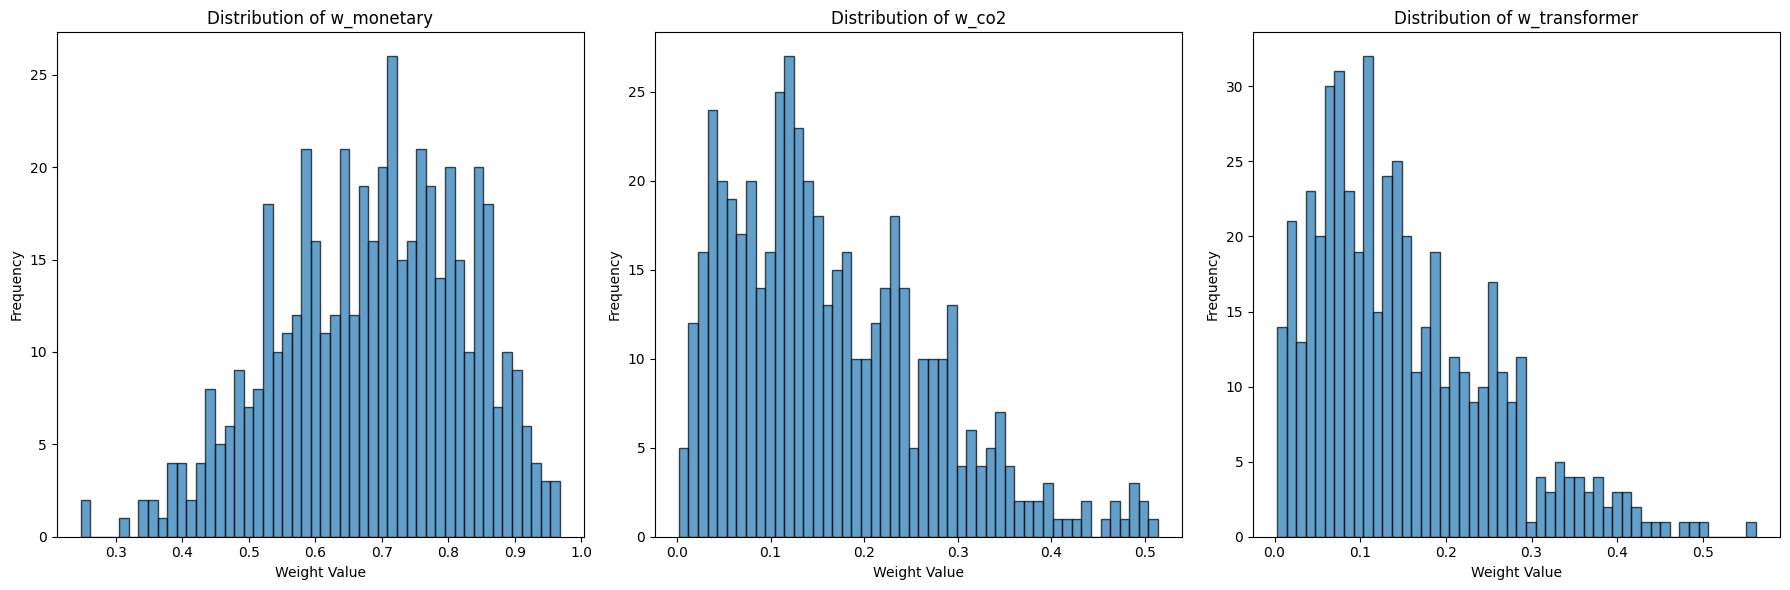

[INFO] Plotting 3D weight distribution...


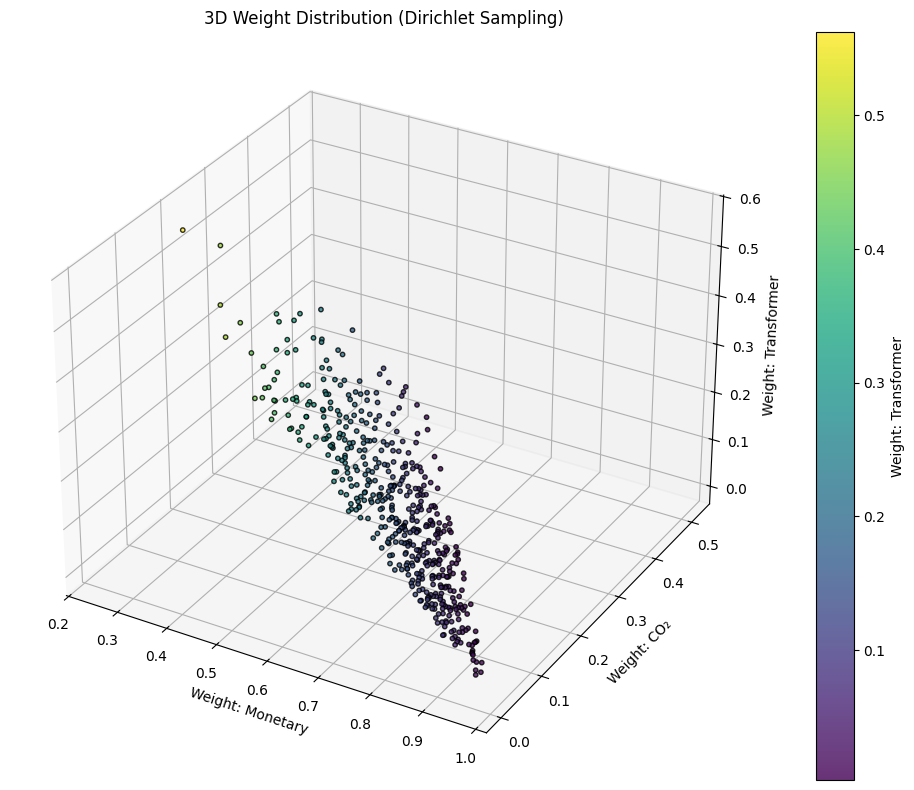

[INFO] Plotting pairwise weight relationships...


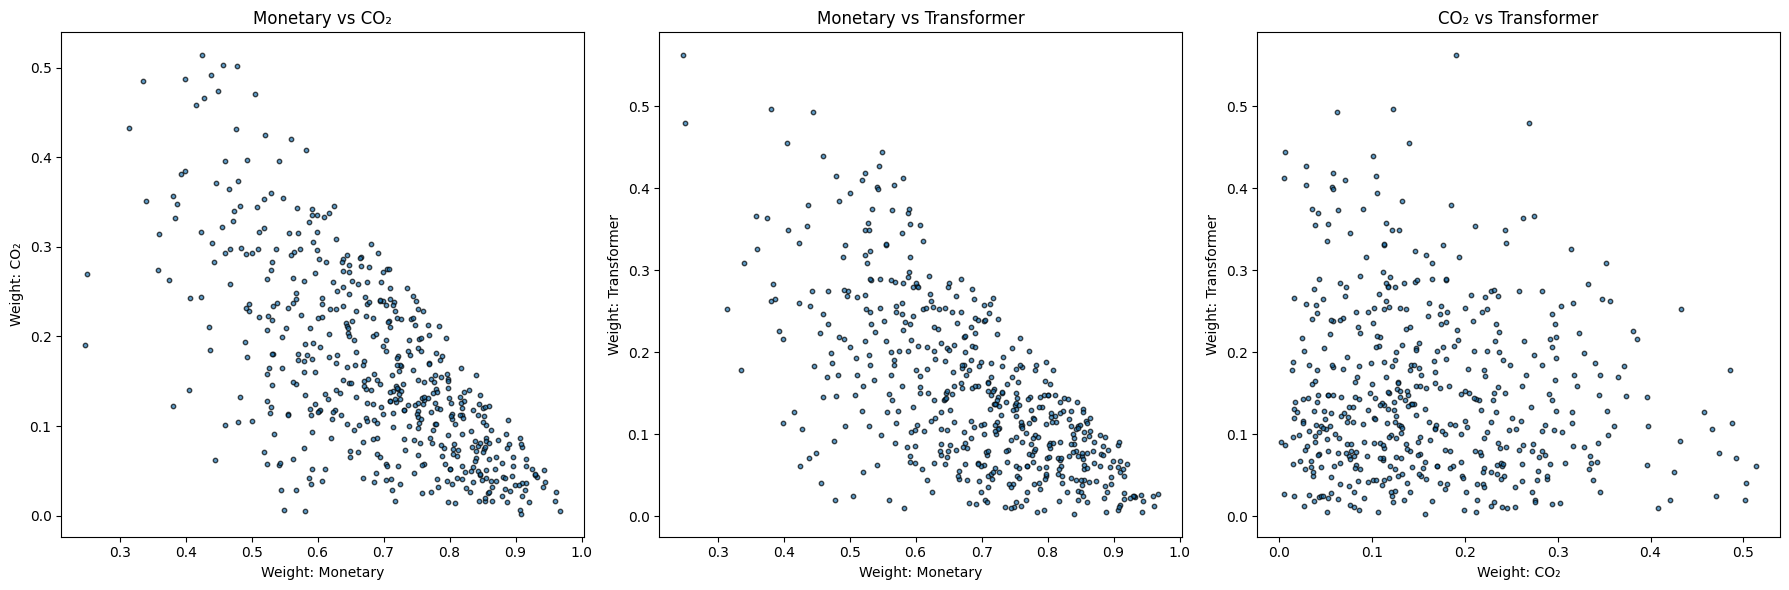

In [5]:
#THE LAST STAND
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ----------------------------
# ⚖️ Dirichlet Weight Generation
# ----------------------------
N_SCENARIOS = 500  # Number of samples
BASE_WEIGHTS = np.array([0.671, 0.173, 0.156])  # Weight ratios from base scenario

# Generate weights using Dirichlet distribution
weights_array = np.random.dirichlet(BASE_WEIGHTS * 10, N_SCENARIOS)  # Scaling for sharper proportionality

# Create a DataFrame for analysis
df_weights = pd.DataFrame(weights_array, columns=["w_monetary", "w_co2", "w_transformer"])

print(f"[INFO] Generated {len(df_weights)} weight samples using Dirichlet distribution.")

# ----------------------------
# 📊 Plot Weight Distributions
# ----------------------------
def plot_weight_distributions(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, weight in enumerate(["w_monetary", "w_co2", "w_transformer"]):
        axes[i].hist(df[weight], bins=50, alpha=0.7, edgecolor='black')
        axes[i].set_title(f"Distribution of {weight}")
        axes[i].set_xlabel('Weight Value')
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


# ----------------------------
# 📊 3D Scatter Plot of Weights
# ----------------------------
def plot_3d_weights(df):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        df["w_monetary"],
        df["w_co2"],
        df["w_transformer"],
        c=df["w_transformer"],
        cmap="viridis",
        s=10,
        alpha=0.8,
        edgecolor='k'
    )

    ax.set_xlabel('Weight: Monetary')
    ax.set_ylabel('Weight: CO₂')
    ax.set_zlabel('Weight: Transformer')
    ax.set_title('3D Weight Distribution (Dirichlet Sampling)')

    cbar = plt.colorbar(scatter)
    cbar.set_label('Weight: Transformer')

    plt.tight_layout()
    plt.show()


# ----------------------------
# 📊 Pairwise Scatter Plots
# ----------------------------
def plot_pairwise_weights(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].scatter(df["w_monetary"], df["w_co2"], alpha=0.7, edgecolor='black', s=10)
    axes[0].set_xlabel('Weight: Monetary')
    axes[0].set_ylabel('Weight: CO₂')
    axes[0].set_title('Monetary vs CO₂')

    axes[1].scatter(df["w_monetary"], df["w_transformer"], alpha=0.7, edgecolor='black', s=10)
    axes[1].set_xlabel('Weight: Monetary')
    axes[1].set_ylabel('Weight: Transformer')
    axes[1].set_title('Monetary vs Transformer')

    axes[2].scatter(df["w_co2"], df["w_transformer"], alpha=0.7, edgecolor='black', s=10)
    axes[2].set_xlabel('Weight: CO₂')
    axes[2].set_ylabel('Weight: Transformer')
    axes[2].set_title('CO₂ vs Transformer')

    plt.tight_layout()
    plt.show()


# ----------------------------
# ▶️ Main Execution
# ----------------------------
if __name__ == "__main__":
    print("[INFO] Plotting weight distributions...")
    plot_weight_distributions(df_weights)

    print("[INFO] Plotting 3D weight distribution...")
    plot_3d_weights(df_weights)

    print("[INFO] Plotting pairwise weight relationships...")
    plot_pairwise_weights(df_weights)


In [2]:
import calliope
import pandas as pd
import xarray as xr
import numpy as np
import os

# ----------------------------
# 📂 Paths and Directories
# ----------------------------
BASE_MODEL_PATH = "/Users/tomdebruin/Library/CloudStorage/OneDrive-DelftUniversityofTechnology/00 THESIS/00 Working Docs/V4/model.yaml"
OUTPUT_DIR = "./pareto_front_runs_dirichlet"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# ----------------------------
# ⚖️ Weight Generation Using Dirichlet Distribution
# ----------------------------
N_SCENARIOS = 500  # Number of weight samples
BASE_WEIGHTS = np.array([0.671, 0.173, 0.156])  # Magnitude ratios from base scenario

# Generate weights using Dirichlet distribution
weights_array = np.random.dirichlet(BASE_WEIGHTS * 10, N_SCENARIOS)  # Scaling for sharper proportionality

# Store weights in a structured format
weights = [
    {
        "w_monetary": round(w[0], 5),
        "w_co2": round(w[1], 5),
        "w_transformer": round(w[2], 5),
    }
    for w in weights_array
]

print(f"[INFO] Generated {len(weights)} weight combinations using Dirichlet distribution.")

# ----------------------------
# 🛠️ Build the Base Model
# ----------------------------
print("[INFO] Building the base model...")
model = calliope.Model(BASE_MODEL_PATH, scenario="year")
model.build()
print("[SUCCESS] Model built successfully.")

# ----------------------------
# ▶️ Run Pareto Front Scenarios
# ----------------------------
results = []

for i, weight in enumerate(weights):
    w_monetary, w_co2, w_transformer = weight["w_monetary"], weight["w_co2"], weight["w_transformer"]
    scenario_name = f"run_wm{w_monetary}_wc{w_co2}_wt{w_transformer}".replace(".", "p")
    print(f"[INFO] Starting scenario: {scenario_name} ({i+1}/{len(weights)})")
    
    try:
        # Update weights dynamically via the backend
        new_weights = xr.DataArray(
            [w_monetary, w_co2, w_transformer],
            dims=["costs"],
            coords={"costs": ["monetary", "co2_emissions", "transformer_congestion_indicator"]}
        )
        print(f"[INFO] Applying weights: {new_weights.values}")
        model.backend.update_parameter("objective_cost_weights", new_weights)

        # Solve the model
        model.solve(force=True)
        print(f"[SUCCESS] Scenario {scenario_name} solved successfully.")

        # Extract costs
        monetary_cost = model.results.cost.sel(costs="monetary").sum().values.item()
        co2_cost = model.results.cost.sel(costs="co2_emissions").sum().values.item()
        transformer_cost = model.results.cost.sel(costs="transformer_congestion_indicator").sum().values.item()
        total_cost = monetary_cost + co2_cost + transformer_cost

        # Save results
        output_file = os.path.join(OUTPUT_DIR, f"{scenario_name}.nc")
        model.to_netcdf(output_file)

        results.append({
            "scenario": scenario_name,
            "total_cost": total_cost,
            "monetary_cost": monetary_cost,
            "co2_cost": co2_cost,
            "transformer_congestion_indicator": transformer_cost,
            "w_monetary": w_monetary,
            "w_co2": w_co2,
            "w_transformer": w_transformer,
        })

    except Exception as e:
        print(f"[ERROR] Run {scenario_name} failed: {e}")
        with open(f"{OUTPUT_DIR}/error_log.txt", "a") as log_file:
            log_file.write(f"Scenario {scenario_name} failed with error: {e}\n")

# ----------------------------
# 💾 Save Results
# ----------------------------
results_df = pd.DataFrame(results)
results_csv_path = os.path.join(OUTPUT_DIR, "all_results.csv")
results_df.to_csv(results_csv_path, index=False)

print(f"[SUCCESS] Completed {len(results_df)} successful runs out of {len(weights)} total runs.")
print(f"[INFO] Results saved to {results_csv_path}")

[INFO] Generated 500 weight combinations using Dirichlet distribution.
[INFO] Building the base model...
[SUCCESS] Model built successfully.
[INFO] Starting scenario: run_wm0p64277_wc0p30076_wt0p05647 (1/500)
[INFO] Applying weights: [0.64277 0.30076 0.05647]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64277_wc0p30076_wt0p05647 solved successfully.
[INFO] Starting scenario: run_wm0p52385_wc0p05937_wt0p41678 (2/500)
[INFO] Applying weights: [0.52385 0.05937 0.41678]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52385_wc0p05937_wt0p41678 solved successfully.
[INFO] Starting scenario: run_wm0p80112_wc0p17447_wt0p02441 (3/500)
[INFO] Applying weights: [0.80112 0.17447 0.02441]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p80112_wc0p17447_wt0p02441 solved successfully.
[INFO] Starting scenario: run_wm0p60814_wc0p34474_wt0p04713 (4/500)
[INFO] Applying weights: [0.60814 0.34474 0.04713]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60814_wc0p34474_wt0p04713 solved successfully.
[INFO] Starting scenario: run_wm0p71467_wc0p17878_wt0p10655 (5/500)
[INFO] Applying weights: [0.71467 0.17878 0.10655]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p71467_wc0p17878_wt0p10655 solved successfully.
[INFO] Starting scenario: run_wm0p39208_wc0p32692_wt0p28101 (6/500)
[INFO] Applying weights: [0.39208 0.32692 0.28101]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p39208_wc0p32692_wt0p28101 solved successfully.
[INFO] Starting scenario: run_wm0p75354_wc0p08634_wt0p16013 (7/500)
[INFO] Applying weights: [0.75354 0.08634 0.16013]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p75354_wc0p08634_wt0p16013 solved successfully.
[INFO] Starting scenario: run_wm0p92648_wc0p05277_wt0p02076 (8/500)
[INFO] Applying weights: [0.92648 0.05277 0.02076]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p92648_wc0p05277_wt0p02076 solved successfully.
[INFO] Starting scenario: run_wm0p47798_wc0p47048_wt0p05154 (9/500)
[INFO] Applying weights: [0.47798 0.47048 0.05154]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p47798_wc0p47048_wt0p05154 solved successfully.
[INFO] Starting scenario: run_wm0p81938_wc0p15592_wt0p0247 (10/500)
[INFO] Applying weights: [0.81938 0.15592 0.0247 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p81938_wc0p15592_wt0p0247 solved successfully.
[INFO] Starting scenario: run_wm0p76468_wc0p17362_wt0p0617 (11/500)
[INFO] Applying weights: [0.76468 0.17362 0.0617 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76468_wc0p17362_wt0p0617 solved successfully.
[INFO] Starting scenario: run_wm0p68643_wc0p20927_wt0p1043 (12/500)
[INFO] Applying weights: [0.68643 0.20927 0.1043 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p68643_wc0p20927_wt0p1043 solved successfully.
[INFO] Starting scenario: run_wm0p72501_wc0p16088_wt0p11411 (13/500)
[INFO] Applying weights: [0.72501 0.16088 0.11411]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72501_wc0p16088_wt0p11411 solved successfully.
[INFO] Starting scenario: run_wm0p81136_wc0p0961_wt0p09254 (14/500)
[INFO] Applying weights: [0.81136 0.0961  0.09254]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81136_wc0p0961_wt0p09254 solved successfully.
[INFO] Starting scenario: run_wm0p54011_wc0p22018_wt0p23971 (15/500)
[INFO] Applying weights: [0.54011 0.22018 0.23971]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p54011_wc0p22018_wt0p23971 solved successfully.
[INFO] Starting scenario: run_wm0p33202_wc0p49864_wt0p16934 (16/500)
[INFO] Applying weights: [0.33202 0.49864 0.16934]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p33202_wc0p49864_wt0p16934 solved successfully.
[INFO] Starting scenario: run_wm0p61431_wc0p26602_wt0p11967 (17/500)
[INFO] Applying weights: [0.61431 0.26602 0.11967]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p61431_wc0p26602_wt0p11967 solved successfully.
[INFO] Starting scenario: run_wm0p40364_wc0p47822_wt0p11814 (18/500)
[INFO] Applying weights: [0.40364 0.47822 0.11814]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p40364_wc0p47822_wt0p11814 solved successfully.
[INFO] Starting scenario: run_wm0p47548_wc0p19514_wt0p32938 (19/500)
[INFO] Applying weights: [0.47548 0.19514 0.32938]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p47548_wc0p19514_wt0p32938 solved successfully.
[INFO] Starting scenario: run_wm0p71156_wc0p25495_wt0p03349 (20/500)
[INFO] Applying weights: [0.71156 0.25495 0.03349]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p71156_wc0p25495_wt0p03349 solved successfully.
[INFO] Starting scenario: run_wm0p51633_wc0p06833_wt0p41534 (21/500)
[INFO] Applying weights: [0.51633 0.06833 0.41534]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p51633_wc0p06833_wt0p41534 solved successfully.
[INFO] Starting scenario: run_wm0p46724_wc0p04823_wt0p48453 (22/500)
[INFO] Applying weights: [0.46724 0.04823 0.48453]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p46724_wc0p04823_wt0p48453 solved successfully.
[INFO] Starting scenario: run_wm0p52546_wc0p15023_wt0p32431 (23/500)
[INFO] Applying weights: [0.52546 0.15023 0.32431]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52546_wc0p15023_wt0p32431 solved successfully.
[INFO] Starting scenario: run_wm0p42388_wc0p35592_wt0p2202 (24/500)
[INFO] Applying weights: [0.42388 0.35592 0.2202 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p42388_wc0p35592_wt0p2202 solved successfully.
[INFO] Starting scenario: run_wm0p68855_wc0p24312_wt0p06832 (25/500)
[INFO] Applying weights: [0.68855 0.24312 0.06832]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p68855_wc0p24312_wt0p06832 solved successfully.
[INFO] Starting scenario: run_wm0p58453_wc0p11611_wt0p29936 (26/500)
[INFO] Applying weights: [0.58453 0.11611 0.29936]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p58453_wc0p11611_wt0p29936 solved successfully.
[INFO] Starting scenario: run_wm0p65225_wc0p10415_wt0p2436 (27/500)
[INFO] Applying weights: [0.65225 0.10415 0.2436 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65225_wc0p10415_wt0p2436 solved successfully.
[INFO] Starting scenario: run_wm0p83438_wc0p12305_wt0p04258 (28/500)
[INFO] Applying weights: [0.83438 0.12305 0.04258]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p83438_wc0p12305_wt0p04258 solved successfully.
[INFO] Starting scenario: run_wm0p49739_wc0p47954_wt0p02307 (29/500)
[INFO] Applying weights: [0.49739 0.47954 0.02307]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p49739_wc0p47954_wt0p02307 solved successfully.
[INFO] Starting scenario: run_wm0p4459_wc0p54304_wt0p01106 (30/500)
[INFO] Applying weights: [0.4459  0.54304 0.01106]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p4459_wc0p54304_wt0p01106 solved successfully.
[INFO] Starting scenario: run_wm0p8015_wc0p17651_wt0p02199 (31/500)
[INFO] Applying weights: [0.8015  0.17651 0.02199]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p8015_wc0p17651_wt0p02199 solved successfully.
[INFO] Starting scenario: run_wm0p75727_wc0p20204_wt0p04069 (32/500)
[INFO] Applying weights: [0.75727 0.20204 0.04069]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p75727_wc0p20204_wt0p04069 solved successfully.
[INFO] Starting scenario: run_wm0p73621_wc0p17422_wt0p08956 (33/500)
[INFO] Applying weights: [0.73621 0.17422 0.08956]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73621_wc0p17422_wt0p08956 solved successfully.
[INFO] Starting scenario: run_wm0p48421_wc0p22434_wt0p29145 (34/500)
[INFO] Applying weights: [0.48421 0.22434 0.29145]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p48421_wc0p22434_wt0p29145 solved successfully.
[INFO] Starting scenario: run_wm0p43787_wc0p41918_wt0p14294 (35/500)
[INFO] Applying weights: [0.43787 0.41918 0.14294]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p43787_wc0p41918_wt0p14294 solved successfully.
[INFO] Starting scenario: run_wm0p82932_wc0p09501_wt0p07567 (36/500)
[INFO] Applying weights: [0.82932 0.09501 0.07567]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p82932_wc0p09501_wt0p07567 solved successfully.
[INFO] Starting scenario: run_wm0p84231_wc0p03199_wt0p1257 (37/500)
[INFO] Applying weights: [0.84231 0.03199 0.1257 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p84231_wc0p03199_wt0p1257 solved successfully.
[INFO] Starting scenario: run_wm0p74454_wc0p15429_wt0p10117 (38/500)
[INFO] Applying weights: [0.74454 0.15429 0.10117]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74454_wc0p15429_wt0p10117 solved successfully.
[INFO] Starting scenario: run_wm0p79711_wc0p17359_wt0p0293 (39/500)
[INFO] Applying weights: [0.79711 0.17359 0.0293 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p79711_wc0p17359_wt0p0293 solved successfully.
[INFO] Starting scenario: run_wm0p74931_wc0p17919_wt0p0715 (40/500)
[INFO] Applying weights: [0.74931 0.17919 0.0715 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74931_wc0p17919_wt0p0715 solved successfully.
[INFO] Starting scenario: run_wm0p78119_wc0p04779_wt0p17102 (41/500)
[INFO] Applying weights: [0.78119 0.04779 0.17102]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p78119_wc0p04779_wt0p17102 solved successfully.
[INFO] Starting scenario: run_wm0p92295_wc0p05016_wt0p02689 (42/500)
[INFO] Applying weights: [0.92295 0.05016 0.02689]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p92295_wc0p05016_wt0p02689 solved successfully.
[INFO] Starting scenario: run_wm0p84623_wc0p04632_wt0p10745 (43/500)
[INFO] Applying weights: [0.84623 0.04632 0.10745]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p84623_wc0p04632_wt0p10745 solved successfully.
[INFO] Starting scenario: run_wm0p40465_wc0p15451_wt0p44084 (44/500)
[INFO] Applying weights: [0.40465 0.15451 0.44084]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p40465_wc0p15451_wt0p44084 solved successfully.
[INFO] Starting scenario: run_wm0p82262_wc0p14834_wt0p02904 (45/500)
[INFO] Applying weights: [0.82262 0.14834 0.02904]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p82262_wc0p14834_wt0p02904 solved successfully.
[INFO] Starting scenario: run_wm0p565_wc0p04824_wt0p38676 (46/500)
[INFO] Applying weights: [0.565   0.04824 0.38676]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p565_wc0p04824_wt0p38676 solved successfully.
[INFO] Starting scenario: run_wm0p67365_wc0p26218_wt0p06416 (47/500)
[INFO] Applying weights: [0.67365 0.26218 0.06416]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67365_wc0p26218_wt0p06416 solved successfully.
[INFO] Starting scenario: run_wm0p7331_wc0p24304_wt0p02387 (48/500)
[INFO] Applying weights: [0.7331  0.24304 0.02387]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7331_wc0p24304_wt0p02387 solved successfully.
[INFO] Starting scenario: run_wm0p46216_wc0p39558_wt0p14226 (49/500)
[INFO] Applying weights: [0.46216 0.39558 0.14226]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p46216_wc0p39558_wt0p14226 solved successfully.
[INFO] Starting scenario: run_wm0p83657_wc0p12463_wt0p0388 (50/500)
[INFO] Applying weights: [0.83657 0.12463 0.0388 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p83657_wc0p12463_wt0p0388 solved successfully.
[INFO] Starting scenario: run_wm0p86277_wc0p12102_wt0p01621 (51/500)
[INFO] Applying weights: [0.86277 0.12102 0.01621]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p86277_wc0p12102_wt0p01621 solved successfully.
[INFO] Starting scenario: run_wm0p4193_wc0p29468_wt0p28603 (52/500)
[INFO] Applying weights: [0.4193  0.29468 0.28603]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p4193_wc0p29468_wt0p28603 solved successfully.
[INFO] Starting scenario: run_wm0p87238_wc0p11906_wt0p00856 (53/500)
[INFO] Applying weights: [0.87238 0.11906 0.00856]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p87238_wc0p11906_wt0p00856 solved successfully.
[INFO] Starting scenario: run_wm0p63855_wc0p23683_wt0p12462 (54/500)
[INFO] Applying weights: [0.63855 0.23683 0.12462]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p63855_wc0p23683_wt0p12462 solved successfully.
[INFO] Starting scenario: run_wm0p85436_wc0p02336_wt0p12228 (55/500)
[INFO] Applying weights: [0.85436 0.02336 0.12228]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p85436_wc0p02336_wt0p12228 solved successfully.
[INFO] Starting scenario: run_wm0p73676_wc0p15553_wt0p1077 (56/500)
[INFO] Applying weights: [0.73676 0.15553 0.1077 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73676_wc0p15553_wt0p1077 solved successfully.
[INFO] Starting scenario: run_wm0p55669_wc0p18812_wt0p2552 (57/500)
[INFO] Applying weights: [0.55669 0.18812 0.2552 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p55669_wc0p18812_wt0p2552 solved successfully.
[INFO] Starting scenario: run_wm0p51043_wc0p42768_wt0p06189 (58/500)
[INFO] Applying weights: [0.51043 0.42768 0.06189]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p51043_wc0p42768_wt0p06189 solved successfully.
[INFO] Starting scenario: run_wm0p76482_wc0p1482_wt0p08698 (59/500)
[INFO] Applying weights: [0.76482 0.1482  0.08698]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76482_wc0p1482_wt0p08698 solved successfully.
[INFO] Starting scenario: run_wm0p60489_wc0p26664_wt0p12847 (60/500)
[INFO] Applying weights: [0.60489 0.26664 0.12847]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60489_wc0p26664_wt0p12847 solved successfully.
[INFO] Starting scenario: run_wm0p65032_wc0p24954_wt0p10015 (61/500)
[INFO] Applying weights: [0.65032 0.24954 0.10015]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65032_wc0p24954_wt0p10015 solved successfully.
[INFO] Starting scenario: run_wm0p76908_wc0p10769_wt0p12323 (62/500)
[INFO] Applying weights: [0.76908 0.10769 0.12323]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76908_wc0p10769_wt0p12323 solved successfully.
[INFO] Starting scenario: run_wm0p6745_wc0p16825_wt0p15725 (63/500)
[INFO] Applying weights: [0.6745  0.16825 0.15725]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6745_wc0p16825_wt0p15725 solved successfully.
[INFO] Starting scenario: run_wm0p59093_wc0p10258_wt0p30649 (64/500)
[INFO] Applying weights: [0.59093 0.10258 0.30649]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p59093_wc0p10258_wt0p30649 solved successfully.
[INFO] Starting scenario: run_wm0p74798_wc0p0216_wt0p23042 (65/500)
[INFO] Applying weights: [0.74798 0.0216  0.23042]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74798_wc0p0216_wt0p23042 solved successfully.
[INFO] Starting scenario: run_wm0p69215_wc0p25634_wt0p05151 (66/500)
[INFO] Applying weights: [0.69215 0.25634 0.05151]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p69215_wc0p25634_wt0p05151 solved successfully.
[INFO] Starting scenario: run_wm0p78386_wc0p08616_wt0p12997 (67/500)
[INFO] Applying weights: [0.78386 0.08616 0.12997]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p78386_wc0p08616_wt0p12997 solved successfully.
[INFO] Starting scenario: run_wm0p6598_wc0p14715_wt0p19305 (68/500)
[INFO] Applying weights: [0.6598  0.14715 0.19305]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6598_wc0p14715_wt0p19305 solved successfully.
[INFO] Starting scenario: run_wm0p48959_wc0p32219_wt0p18822 (69/500)
[INFO] Applying weights: [0.48959 0.32219 0.18822]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p48959_wc0p32219_wt0p18822 solved successfully.
[INFO] Starting scenario: run_wm0p76982_wc0p07398_wt0p1562 (70/500)
[INFO] Applying weights: [0.76982 0.07398 0.1562 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76982_wc0p07398_wt0p1562 solved successfully.
[INFO] Starting scenario: run_wm0p7576_wc0p13756_wt0p10484 (71/500)
[INFO] Applying weights: [0.7576  0.13756 0.10484]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7576_wc0p13756_wt0p10484 solved successfully.
[INFO] Starting scenario: run_wm0p33206_wc0p07435_wt0p59359 (72/500)
[INFO] Applying weights: [0.33206 0.07435 0.59359]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p33206_wc0p07435_wt0p59359 solved successfully.
[INFO] Starting scenario: run_wm0p84673_wc0p12099_wt0p03228 (73/500)
[INFO] Applying weights: [0.84673 0.12099 0.03228]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p84673_wc0p12099_wt0p03228 solved successfully.
[INFO] Starting scenario: run_wm0p89004_wc0p04428_wt0p06568 (74/500)
[INFO] Applying weights: [0.89004 0.04428 0.06568]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p89004_wc0p04428_wt0p06568 solved successfully.
[INFO] Starting scenario: run_wm0p76064_wc0p03538_wt0p20398 (75/500)
[INFO] Applying weights: [0.76064 0.03538 0.20398]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76064_wc0p03538_wt0p20398 solved successfully.
[INFO] Starting scenario: run_wm0p60298_wc0p30429_wt0p09272 (76/500)
[INFO] Applying weights: [0.60298 0.30429 0.09272]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60298_wc0p30429_wt0p09272 solved successfully.
[INFO] Starting scenario: run_wm0p69072_wc0p0991_wt0p21018 (77/500)
[INFO] Applying weights: [0.69072 0.0991  0.21018]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p69072_wc0p0991_wt0p21018 solved successfully.
[INFO] Starting scenario: run_wm0p69096_wc0p11996_wt0p18908 (78/500)
[INFO] Applying weights: [0.69096 0.11996 0.18908]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p69096_wc0p11996_wt0p18908 solved successfully.
[INFO] Starting scenario: run_wm0p77542_wc0p1935_wt0p03108 (79/500)
[INFO] Applying weights: [0.77542 0.1935  0.03108]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p77542_wc0p1935_wt0p03108 solved successfully.
[INFO] Starting scenario: run_wm0p76589_wc0p08569_wt0p14842 (80/500)
[INFO] Applying weights: [0.76589 0.08569 0.14842]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76589_wc0p08569_wt0p14842 solved successfully.
[INFO] Starting scenario: run_wm0p82567_wc0p11867_wt0p05566 (81/500)
[INFO] Applying weights: [0.82567 0.11867 0.05566]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p82567_wc0p11867_wt0p05566 solved successfully.
[INFO] Starting scenario: run_wm0p64071_wc0p27339_wt0p0859 (82/500)
[INFO] Applying weights: [0.64071 0.27339 0.0859 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64071_wc0p27339_wt0p0859 solved successfully.
[INFO] Starting scenario: run_wm0p77765_wc0p05055_wt0p1718 (83/500)
[INFO] Applying weights: [0.77765 0.05055 0.1718 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p77765_wc0p05055_wt0p1718 solved successfully.
[INFO] Starting scenario: run_wm0p70115_wc0p13242_wt0p16643 (84/500)
[INFO] Applying weights: [0.70115 0.13242 0.16643]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70115_wc0p13242_wt0p16643 solved successfully.
[INFO] Starting scenario: run_wm0p42943_wc0p12026_wt0p45031 (85/500)
[INFO] Applying weights: [0.42943 0.12026 0.45031]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p42943_wc0p12026_wt0p45031 solved successfully.
[INFO] Starting scenario: run_wm0p90764_wc0p08243_wt0p00992 (86/500)
[INFO] Applying weights: [0.90764 0.08243 0.00992]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p90764_wc0p08243_wt0p00992 solved successfully.
[INFO] Starting scenario: run_wm0p70483_wc0p26475_wt0p03041 (87/500)
[INFO] Applying weights: [0.70483 0.26475 0.03041]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70483_wc0p26475_wt0p03041 solved successfully.
[INFO] Starting scenario: run_wm0p73989_wc0p13057_wt0p12954 (88/500)
[INFO] Applying weights: [0.73989 0.13057 0.12954]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73989_wc0p13057_wt0p12954 solved successfully.
[INFO] Starting scenario: run_wm0p43381_wc0p52648_wt0p03971 (89/500)
[INFO] Applying weights: [0.43381 0.52648 0.03971]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p43381_wc0p52648_wt0p03971 solved successfully.
[INFO] Starting scenario: run_wm0p86472_wc0p06208_wt0p0732 (90/500)
[INFO] Applying weights: [0.86472 0.06208 0.0732 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p86472_wc0p06208_wt0p0732 solved successfully.
[INFO] Starting scenario: run_wm0p63922_wc0p22445_wt0p13633 (91/500)
[INFO] Applying weights: [0.63922 0.22445 0.13633]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p63922_wc0p22445_wt0p13633 solved successfully.
[INFO] Starting scenario: run_wm0p72273_wc0p10369_wt0p17358 (92/500)
[INFO] Applying weights: [0.72273 0.10369 0.17358]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72273_wc0p10369_wt0p17358 solved successfully.
[INFO] Starting scenario: run_wm0p45392_wc0p38012_wt0p16596 (93/500)
[INFO] Applying weights: [0.45392 0.38012 0.16596]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p45392_wc0p38012_wt0p16596 solved successfully.
[INFO] Starting scenario: run_wm0p5623_wc0p14226_wt0p29544 (94/500)
[INFO] Applying weights: [0.5623  0.14226 0.29544]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p5623_wc0p14226_wt0p29544 solved successfully.
[INFO] Starting scenario: run_wm0p85137_wc0p12971_wt0p01893 (95/500)
[INFO] Applying weights: [0.85137 0.12971 0.01893]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p85137_wc0p12971_wt0p01893 solved successfully.
[INFO] Starting scenario: run_wm0p46023_wc0p28595_wt0p25382 (96/500)
[INFO] Applying weights: [0.46023 0.28595 0.25382]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p46023_wc0p28595_wt0p25382 solved successfully.
[INFO] Starting scenario: run_wm0p71453_wc0p16029_wt0p12518 (97/500)
[INFO] Applying weights: [0.71453 0.16029 0.12518]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p71453_wc0p16029_wt0p12518 solved successfully.
[INFO] Starting scenario: run_wm0p61235_wc0p20305_wt0p1846 (98/500)
[INFO] Applying weights: [0.61235 0.20305 0.1846 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p61235_wc0p20305_wt0p1846 solved successfully.
[INFO] Starting scenario: run_wm0p63484_wc0p16683_wt0p19832 (99/500)
[INFO] Applying weights: [0.63484 0.16683 0.19832]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p63484_wc0p16683_wt0p19832 solved successfully.
[INFO] Starting scenario: run_wm0p50584_wc0p0824_wt0p41176 (100/500)
[INFO] Applying weights: [0.50584 0.0824  0.41176]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p50584_wc0p0824_wt0p41176 solved successfully.
[INFO] Starting scenario: run_wm0p43277_wc0p45751_wt0p10972 (101/500)
[INFO] Applying weights: [0.43277 0.45751 0.10972]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p43277_wc0p45751_wt0p10972 solved successfully.
[INFO] Starting scenario: run_wm0p7532_wc0p06779_wt0p17902 (102/500)
[INFO] Applying weights: [0.7532  0.06779 0.17902]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7532_wc0p06779_wt0p17902 solved successfully.
[INFO] Starting scenario: run_wm0p81335_wc0p07496_wt0p11169 (103/500)
[INFO] Applying weights: [0.81335 0.07496 0.11169]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81335_wc0p07496_wt0p11169 solved successfully.
[INFO] Starting scenario: run_wm0p55429_wc0p36537_wt0p08035 (104/500)
[INFO] Applying weights: [0.55429 0.36537 0.08035]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p55429_wc0p36537_wt0p08035 solved successfully.
[INFO] Starting scenario: run_wm0p70142_wc0p14617_wt0p15241 (105/500)
[INFO] Applying weights: [0.70142 0.14617 0.15241]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70142_wc0p14617_wt0p15241 solved successfully.
[INFO] Starting scenario: run_wm0p5292_wc0p21974_wt0p25106 (106/500)
[INFO] Applying weights: [0.5292  0.21974 0.25106]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p5292_wc0p21974_wt0p25106 solved successfully.
[INFO] Starting scenario: run_wm0p62297_wc0p07981_wt0p29722 (107/500)
[INFO] Applying weights: [0.62297 0.07981 0.29722]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p62297_wc0p07981_wt0p29722 solved successfully.
[INFO] Starting scenario: run_wm0p57335_wc0p32392_wt0p10273 (108/500)
[INFO] Applying weights: [0.57335 0.32392 0.10273]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p57335_wc0p32392_wt0p10273 solved successfully.
[INFO] Starting scenario: run_wm0p74674_wc0p19551_wt0p05775 (109/500)
[INFO] Applying weights: [0.74674 0.19551 0.05775]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74674_wc0p19551_wt0p05775 solved successfully.
[INFO] Starting scenario: run_wm0p53034_wc0p17285_wt0p2968 (110/500)
[INFO] Applying weights: [0.53034 0.17285 0.2968 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p53034_wc0p17285_wt0p2968 solved successfully.
[INFO] Starting scenario: run_wm0p61501_wc0p31282_wt0p07217 (111/500)
[INFO] Applying weights: [0.61501 0.31282 0.07217]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p61501_wc0p31282_wt0p07217 solved successfully.
[INFO] Starting scenario: run_wm0p58946_wc0p30217_wt0p10838 (112/500)
[INFO] Applying weights: [0.58946 0.30217 0.10838]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p58946_wc0p30217_wt0p10838 solved successfully.
[INFO] Starting scenario: run_wm0p27342_wc0p64784_wt0p07874 (113/500)
[INFO] Applying weights: [0.27342 0.64784 0.07874]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p27342_wc0p64784_wt0p07874 solved successfully.
[INFO] Starting scenario: run_wm0p81129_wc0p17625_wt0p01246 (114/500)
[INFO] Applying weights: [0.81129 0.17625 0.01246]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81129_wc0p17625_wt0p01246 solved successfully.
[INFO] Starting scenario: run_wm0p91198_wc0p06967_wt0p01835 (115/500)
[INFO] Applying weights: [0.91198 0.06967 0.01835]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p91198_wc0p06967_wt0p01835 solved successfully.
[INFO] Starting scenario: run_wm0p74813_wc0p23063_wt0p02124 (116/500)
[INFO] Applying weights: [0.74813 0.23063 0.02124]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74813_wc0p23063_wt0p02124 solved successfully.
[INFO] Starting scenario: run_wm0p50934_wc0p29807_wt0p19259 (117/500)
[INFO] Applying weights: [0.50934 0.29807 0.19259]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p50934_wc0p29807_wt0p19259 solved successfully.
[INFO] Starting scenario: run_wm0p69978_wc0p08724_wt0p21298 (118/500)
[INFO] Applying weights: [0.69978 0.08724 0.21298]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p69978_wc0p08724_wt0p21298 solved successfully.
[INFO] Starting scenario: run_wm0p71961_wc0p02507_wt0p25532 (119/500)
[INFO] Applying weights: [0.71961 0.02507 0.25532]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p71961_wc0p02507_wt0p25532 solved successfully.
[INFO] Starting scenario: run_wm0p6839_wc0p27506_wt0p04104 (120/500)
[INFO] Applying weights: [0.6839  0.27506 0.04104]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6839_wc0p27506_wt0p04104 solved successfully.
[INFO] Starting scenario: run_wm0p56499_wc0p12359_wt0p31142 (121/500)
[INFO] Applying weights: [0.56499 0.12359 0.31142]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p56499_wc0p12359_wt0p31142 solved successfully.
[INFO] Starting scenario: run_wm0p48117_wc0p22033_wt0p29849 (122/500)
[INFO] Applying weights: [0.48117 0.22033 0.29849]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p48117_wc0p22033_wt0p29849 solved successfully.
[INFO] Starting scenario: run_wm0p64481_wc0p27185_wt0p08334 (123/500)
[INFO] Applying weights: [0.64481 0.27185 0.08334]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64481_wc0p27185_wt0p08334 solved successfully.
[INFO] Starting scenario: run_wm0p67349_wc0p25216_wt0p07436 (124/500)
[INFO] Applying weights: [0.67349 0.25216 0.07436]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67349_wc0p25216_wt0p07436 solved successfully.
[INFO] Starting scenario: run_wm0p73636_wc0p0373_wt0p22634 (125/500)
[INFO] Applying weights: [0.73636 0.0373  0.22634]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73636_wc0p0373_wt0p22634 solved successfully.
[INFO] Starting scenario: run_wm0p73646_wc0p22993_wt0p03361 (126/500)
[INFO] Applying weights: [0.73646 0.22993 0.03361]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73646_wc0p22993_wt0p03361 solved successfully.
[INFO] Starting scenario: run_wm0p84868_wc0p12391_wt0p02741 (127/500)
[INFO] Applying weights: [0.84868 0.12391 0.02741]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p84868_wc0p12391_wt0p02741 solved successfully.
[INFO] Starting scenario: run_wm0p70565_wc0p09241_wt0p20194 (128/500)
[INFO] Applying weights: [0.70565 0.09241 0.20194]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70565_wc0p09241_wt0p20194 solved successfully.
[INFO] Starting scenario: run_wm0p48553_wc0p3248_wt0p18967 (129/500)
[INFO] Applying weights: [0.48553 0.3248  0.18967]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p48553_wc0p3248_wt0p18967 solved successfully.
[INFO] Starting scenario: run_wm0p71221_wc0p17092_wt0p11686 (130/500)
[INFO] Applying weights: [0.71221 0.17092 0.11686]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p71221_wc0p17092_wt0p11686 solved successfully.
[INFO] Starting scenario: run_wm0p73716_wc0p23932_wt0p02352 (131/500)
[INFO] Applying weights: [0.73716 0.23932 0.02352]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73716_wc0p23932_wt0p02352 solved successfully.
[INFO] Starting scenario: run_wm0p60843_wc0p37067_wt0p02089 (132/500)
[INFO] Applying weights: [0.60843 0.37067 0.02089]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p60843_wc0p37067_wt0p02089 solved successfully.
[INFO] Starting scenario: run_wm0p62339_wc0p07139_wt0p30522 (133/500)
[INFO] Applying weights: [0.62339 0.07139 0.30522]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p62339_wc0p07139_wt0p30522 solved successfully.
[INFO] Starting scenario: run_wm0p83397_wc0p10288_wt0p06315 (134/500)
[INFO] Applying weights: [0.83397 0.10288 0.06315]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p83397_wc0p10288_wt0p06315 solved successfully.
[INFO] Starting scenario: run_wm0p4406_wc0p21817_wt0p34123 (135/500)
[INFO] Applying weights: [0.4406  0.21817 0.34123]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p4406_wc0p21817_wt0p34123 solved successfully.
[INFO] Starting scenario: run_wm0p85633_wc0p09831_wt0p04535 (136/500)
[INFO] Applying weights: [0.85633 0.09831 0.04535]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p85633_wc0p09831_wt0p04535 solved successfully.
[INFO] Starting scenario: run_wm0p63338_wc0p2072_wt0p15942 (137/500)
[INFO] Applying weights: [0.63338 0.2072  0.15942]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p63338_wc0p2072_wt0p15942 solved successfully.
[INFO] Starting scenario: run_wm0p78659_wc0p12043_wt0p09298 (138/500)
[INFO] Applying weights: [0.78659 0.12043 0.09298]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p78659_wc0p12043_wt0p09298 solved successfully.
[INFO] Starting scenario: run_wm0p81333_wc0p12361_wt0p06306 (139/500)
[INFO] Applying weights: [0.81333 0.12361 0.06306]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81333_wc0p12361_wt0p06306 solved successfully.
[INFO] Starting scenario: run_wm0p88502_wc0p01096_wt0p10402 (140/500)
[INFO] Applying weights: [0.88502 0.01096 0.10402]


Problem status:

Name: x1
Lower bound: -inf
Upper bound: inf
Number of objectives: 1
Number of constraints: 1191378
Number of variables: 709629
Number of binary variables: 0
Number of integer variables: 0
Number of continuous variables: 709629
Number of nonzeros: 2894931
Sense: minimize

Solver status:

Status: warning
Return code: 0
Message: Problem proven to be infeasible or unbounded.
Termination condition: infeasibleOrUnbounded
Termination message: Problem proven to be infeasible or unbounded.
Wall time: 0.2330338954925537
Error rc: 0
Time: 3.268767833709717



[SUCCESS] Scenario run_wm0p88502_wc0p01096_wt0p10402 solved successfully.
[ERROR] Run run_wm0p88502_wc0p01096_wt0p10402 failed: 'Dataset' object has no attribute 'cost'
[INFO] Starting scenario: run_wm0p57635_wc0p25634_wt0p16731 (141/500)
[INFO] Applying weights: [0.57635 0.25634 0.16731]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p57635_wc0p25634_wt0p16731 solved successfully.
[INFO] Starting scenario: run_wm0p76214_wc0p0334_wt0p20446 (142/500)
[INFO] Applying weights: [0.76214 0.0334  0.20446]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76214_wc0p0334_wt0p20446 solved successfully.
[INFO] Starting scenario: run_wm0p86794_wc0p08578_wt0p04628 (143/500)
[INFO] Applying weights: [0.86794 0.08578 0.04628]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p86794_wc0p08578_wt0p04628 solved successfully.
[INFO] Starting scenario: run_wm0p43072_wc0p31821_wt0p25107 (144/500)
[INFO] Applying weights: [0.43072 0.31821 0.25107]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p43072_wc0p31821_wt0p25107 solved successfully.
[INFO] Starting scenario: run_wm0p63043_wc0p0631_wt0p30647 (145/500)
[INFO] Applying weights: [0.63043 0.0631  0.30647]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p63043_wc0p0631_wt0p30647 solved successfully.
[INFO] Starting scenario: run_wm0p74394_wc0p20185_wt0p05421 (146/500)
[INFO] Applying weights: [0.74394 0.20185 0.05421]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p74394_wc0p20185_wt0p05421 solved successfully.
[INFO] Starting scenario: run_wm0p74993_wc0p17557_wt0p07451 (147/500)
[INFO] Applying weights: [0.74993 0.17557 0.07451]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74993_wc0p17557_wt0p07451 solved successfully.
[INFO] Starting scenario: run_wm0p67594_wc0p14686_wt0p1772 (148/500)
[INFO] Applying weights: [0.67594 0.14686 0.1772 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67594_wc0p14686_wt0p1772 solved successfully.
[INFO] Starting scenario: run_wm0p47061_wc0p50062_wt0p02878 (149/500)
[INFO] Applying weights: [0.47061 0.50062 0.02878]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p47061_wc0p50062_wt0p02878 solved successfully.
[INFO] Starting scenario: run_wm0p64522_wc0p24592_wt0p10885 (150/500)
[INFO] Applying weights: [0.64522 0.24592 0.10885]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64522_wc0p24592_wt0p10885 solved successfully.
[INFO] Starting scenario: run_wm0p64089_wc0p25956_wt0p09954 (151/500)
[INFO] Applying weights: [0.64089 0.25956 0.09954]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64089_wc0p25956_wt0p09954 solved successfully.
[INFO] Starting scenario: run_wm0p6578_wc0p27891_wt0p0633 (152/500)
[INFO] Applying weights: [0.6578  0.27891 0.0633 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6578_wc0p27891_wt0p0633 solved successfully.
[INFO] Starting scenario: run_wm0p73795_wc0p06117_wt0p20089 (153/500)
[INFO] Applying weights: [0.73795 0.06117 0.20089]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73795_wc0p06117_wt0p20089 solved successfully.
[INFO] Starting scenario: run_wm0p56159_wc0p19342_wt0p24499 (154/500)
[INFO] Applying weights: [0.56159 0.19342 0.24499]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p56159_wc0p19342_wt0p24499 solved successfully.
[INFO] Starting scenario: run_wm0p64085_wc0p15729_wt0p20186 (155/500)
[INFO] Applying weights: [0.64085 0.15729 0.20186]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64085_wc0p15729_wt0p20186 solved successfully.
[INFO] Starting scenario: run_wm0p5828_wc0p39258_wt0p02462 (156/500)
[INFO] Applying weights: [0.5828  0.39258 0.02462]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p5828_wc0p39258_wt0p02462 solved successfully.
[INFO] Starting scenario: run_wm0p7062_wc0p27817_wt0p01563 (157/500)
[INFO] Applying weights: [0.7062  0.27817 0.01563]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p7062_wc0p27817_wt0p01563 solved successfully.
[INFO] Starting scenario: run_wm0p7513_wc0p05052_wt0p19818 (158/500)
[INFO] Applying weights: [0.7513  0.05052 0.19818]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7513_wc0p05052_wt0p19818 solved successfully.
[INFO] Starting scenario: run_wm0p40965_wc0p05345_wt0p5369 (159/500)
[INFO] Applying weights: [0.40965 0.05345 0.5369 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p40965_wc0p05345_wt0p5369 solved successfully.
[INFO] Starting scenario: run_wm0p8473_wc0p13724_wt0p01546 (160/500)
[INFO] Applying weights: [0.8473  0.13724 0.01546]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p8473_wc0p13724_wt0p01546 solved successfully.
[INFO] Starting scenario: run_wm0p92601_wc0p02788_wt0p04611 (161/500)
[INFO] Applying weights: [0.92601 0.02788 0.04611]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p92601_wc0p02788_wt0p04611 solved successfully.
[INFO] Starting scenario: run_wm0p82964_wc0p12559_wt0p04477 (162/500)
[INFO] Applying weights: [0.82964 0.12559 0.04477]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p82964_wc0p12559_wt0p04477 solved successfully.
[INFO] Starting scenario: run_wm0p81082_wc0p07492_wt0p11426 (163/500)
[INFO] Applying weights: [0.81082 0.07492 0.11426]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81082_wc0p07492_wt0p11426 solved successfully.
[INFO] Starting scenario: run_wm0p55964_wc0p17093_wt0p26942 (164/500)
[INFO] Applying weights: [0.55964 0.17093 0.26942]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p55964_wc0p17093_wt0p26942 solved successfully.
[INFO] Starting scenario: run_wm0p84244_wc0p11275_wt0p04481 (165/500)
[INFO] Applying weights: [0.84244 0.11275 0.04481]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p84244_wc0p11275_wt0p04481 solved successfully.
[INFO] Starting scenario: run_wm0p64147_wc0p05562_wt0p30291 (166/500)
[INFO] Applying weights: [0.64147 0.05562 0.30291]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64147_wc0p05562_wt0p30291 solved successfully.
[INFO] Starting scenario: run_wm0p72955_wc0p12181_wt0p14864 (167/500)
[INFO] Applying weights: [0.72955 0.12181 0.14864]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72955_wc0p12181_wt0p14864 solved successfully.
[INFO] Starting scenario: run_wm0p66779_wc0p05828_wt0p27392 (168/500)
[INFO] Applying weights: [0.66779 0.05828 0.27392]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p66779_wc0p05828_wt0p27392 solved successfully.
[INFO] Starting scenario: run_wm0p64696_wc0p26493_wt0p08812 (169/500)
[INFO] Applying weights: [0.64696 0.26493 0.08812]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64696_wc0p26493_wt0p08812 solved successfully.
[INFO] Starting scenario: run_wm0p62743_wc0p3714_wt0p00117 (170/500)
[INFO] Applying weights: [0.62743 0.3714  0.00117]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p62743_wc0p3714_wt0p00117 solved successfully.
[INFO] Starting scenario: run_wm0p37883_wc0p52985_wt0p09132 (171/500)
[INFO] Applying weights: [0.37883 0.52985 0.09132]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p37883_wc0p52985_wt0p09132 solved successfully.
[INFO] Starting scenario: run_wm0p58697_wc0p08575_wt0p32728 (172/500)
[INFO] Applying weights: [0.58697 0.08575 0.32728]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p58697_wc0p08575_wt0p32728 solved successfully.
[INFO] Starting scenario: run_wm0p4424_wc0p47038_wt0p08722 (173/500)
[INFO] Applying weights: [0.4424  0.47038 0.08722]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p4424_wc0p47038_wt0p08722 solved successfully.
[INFO] Starting scenario: run_wm0p62374_wc0p1481_wt0p22816 (174/500)
[INFO] Applying weights: [0.62374 0.1481  0.22816]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p62374_wc0p1481_wt0p22816 solved successfully.
[INFO] Starting scenario: run_wm0p90881_wc0p0069_wt0p08429 (175/500)
[INFO] Applying weights: [0.90881 0.0069  0.08429]


Problem status:

Name: x1
Lower bound: -inf
Upper bound: inf
Number of objectives: 1
Number of constraints: 1191378
Number of variables: 709629
Number of binary variables: 0
Number of integer variables: 0
Number of continuous variables: 709629
Number of nonzeros: 2894931
Sense: minimize

Solver status:

Status: warning
Return code: 0
Message: Problem proven to be infeasible or unbounded.
Termination condition: infeasibleOrUnbounded
Termination message: Problem proven to be infeasible or unbounded.
Wall time: 0.2188119888305664
Error rc: 0
Time: 3.054795026779175



[SUCCESS] Scenario run_wm0p90881_wc0p0069_wt0p08429 solved successfully.
[ERROR] Run run_wm0p90881_wc0p0069_wt0p08429 failed: 'Dataset' object has no attribute 'cost'
[INFO] Starting scenario: run_wm0p79514_wc0p09179_wt0p11307 (176/500)
[INFO] Applying weights: [0.79514 0.09179 0.11307]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p79514_wc0p09179_wt0p11307 solved successfully.
[INFO] Starting scenario: run_wm0p56681_wc0p25987_wt0p17332 (177/500)
[INFO] Applying weights: [0.56681 0.25987 0.17332]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p56681_wc0p25987_wt0p17332 solved successfully.
[INFO] Starting scenario: run_wm0p41556_wc0p26774_wt0p3167 (178/500)
[INFO] Applying weights: [0.41556 0.26774 0.3167 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p41556_wc0p26774_wt0p3167 solved successfully.
[INFO] Starting scenario: run_wm0p90047_wc0p05176_wt0p04777 (179/500)
[INFO] Applying weights: [0.90047 0.05176 0.04777]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p90047_wc0p05176_wt0p04777 solved successfully.
[INFO] Starting scenario: run_wm0p85925_wc0p12802_wt0p01273 (180/500)
[INFO] Applying weights: [0.85925 0.12802 0.01273]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p85925_wc0p12802_wt0p01273 solved successfully.
[INFO] Starting scenario: run_wm0p53266_wc0p2144_wt0p25294 (181/500)
[INFO] Applying weights: [0.53266 0.2144  0.25294]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p53266_wc0p2144_wt0p25294 solved successfully.
[INFO] Starting scenario: run_wm0p50713_wc0p42834_wt0p06453 (182/500)
[INFO] Applying weights: [0.50713 0.42834 0.06453]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p50713_wc0p42834_wt0p06453 solved successfully.
[INFO] Starting scenario: run_wm0p55153_wc0p05726_wt0p39122 (183/500)
[INFO] Applying weights: [0.55153 0.05726 0.39122]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p55153_wc0p05726_wt0p39122 solved successfully.
[INFO] Starting scenario: run_wm0p64656_wc0p16421_wt0p18923 (184/500)
[INFO] Applying weights: [0.64656 0.16421 0.18923]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64656_wc0p16421_wt0p18923 solved successfully.
[INFO] Starting scenario: run_wm0p70964_wc0p20588_wt0p08447 (185/500)
[INFO] Applying weights: [0.70964 0.20588 0.08447]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70964_wc0p20588_wt0p08447 solved successfully.
[INFO] Starting scenario: run_wm0p73104_wc0p2198_wt0p04916 (186/500)
[INFO] Applying weights: [0.73104 0.2198  0.04916]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73104_wc0p2198_wt0p04916 solved successfully.
[INFO] Starting scenario: run_wm0p52849_wc0p34431_wt0p1272 (187/500)
[INFO] Applying weights: [0.52849 0.34431 0.1272 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52849_wc0p34431_wt0p1272 solved successfully.
[INFO] Starting scenario: run_wm0p60124_wc0p23982_wt0p15894 (188/500)
[INFO] Applying weights: [0.60124 0.23982 0.15894]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60124_wc0p23982_wt0p15894 solved successfully.
[INFO] Starting scenario: run_wm0p95811_wc0p03868_wt0p00321 (189/500)
[INFO] Applying weights: [0.95811 0.03868 0.00321]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p95811_wc0p03868_wt0p00321 solved successfully.
[INFO] Starting scenario: run_wm0p67307_wc0p27272_wt0p05421 (190/500)
[INFO] Applying weights: [0.67307 0.27272 0.05421]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67307_wc0p27272_wt0p05421 solved successfully.
[INFO] Starting scenario: run_wm0p72889_wc0p26498_wt0p00613 (191/500)
[INFO] Applying weights: [0.72889 0.26498 0.00613]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72889_wc0p26498_wt0p00613 solved successfully.
[INFO] Starting scenario: run_wm0p52366_wc0p14549_wt0p33085 (192/500)
[INFO] Applying weights: [0.52366 0.14549 0.33085]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52366_wc0p14549_wt0p33085 solved successfully.
[INFO] Starting scenario: run_wm0p57746_wc0p10262_wt0p31991 (193/500)
[INFO] Applying weights: [0.57746 0.10262 0.31991]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p57746_wc0p10262_wt0p31991 solved successfully.
[INFO] Starting scenario: run_wm0p77895_wc0p11249_wt0p10856 (194/500)
[INFO] Applying weights: [0.77895 0.11249 0.10856]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p77895_wc0p11249_wt0p10856 solved successfully.
[INFO] Starting scenario: run_wm0p63955_wc0p24821_wt0p11224 (195/500)
[INFO] Applying weights: [0.63955 0.24821 0.11224]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p63955_wc0p24821_wt0p11224 solved successfully.
[INFO] Starting scenario: run_wm0p43368_wc0p18796_wt0p37836 (196/500)
[INFO] Applying weights: [0.43368 0.18796 0.37836]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p43368_wc0p18796_wt0p37836 solved successfully.
[INFO] Starting scenario: run_wm0p55635_wc0p02813_wt0p41552 (197/500)
[INFO] Applying weights: [0.55635 0.02813 0.41552]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p55635_wc0p02813_wt0p41552 solved successfully.
[INFO] Starting scenario: run_wm0p65675_wc0p24291_wt0p10034 (198/500)
[INFO] Applying weights: [0.65675 0.24291 0.10034]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65675_wc0p24291_wt0p10034 solved successfully.
[INFO] Starting scenario: run_wm0p79679_wc0p05331_wt0p1499 (199/500)
[INFO] Applying weights: [0.79679 0.05331 0.1499 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p79679_wc0p05331_wt0p1499 solved successfully.
[INFO] Starting scenario: run_wm0p65586_wc0p17592_wt0p16822 (200/500)
[INFO] Applying weights: [0.65586 0.17592 0.16822]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65586_wc0p17592_wt0p16822 solved successfully.
[INFO] Starting scenario: run_wm0p44073_wc0p38848_wt0p17078 (201/500)
[INFO] Applying weights: [0.44073 0.38848 0.17078]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p44073_wc0p38848_wt0p17078 solved successfully.
[INFO] Starting scenario: run_wm0p86336_wc0p04579_wt0p09085 (202/500)
[INFO] Applying weights: [0.86336 0.04579 0.09085]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p86336_wc0p04579_wt0p09085 solved successfully.
[INFO] Starting scenario: run_wm0p65222_wc0p08068_wt0p2671 (203/500)
[INFO] Applying weights: [0.65222 0.08068 0.2671 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65222_wc0p08068_wt0p2671 solved successfully.
[INFO] Starting scenario: run_wm0p47275_wc0p25327_wt0p27398 (204/500)
[INFO] Applying weights: [0.47275 0.25327 0.27398]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p47275_wc0p25327_wt0p27398 solved successfully.
[INFO] Starting scenario: run_wm0p52797_wc0p35852_wt0p11351 (205/500)
[INFO] Applying weights: [0.52797 0.35852 0.11351]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52797_wc0p35852_wt0p11351 solved successfully.
[INFO] Starting scenario: run_wm0p75215_wc0p20006_wt0p04779 (206/500)
[INFO] Applying weights: [0.75215 0.20006 0.04779]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p75215_wc0p20006_wt0p04779 solved successfully.
[INFO] Starting scenario: run_wm0p52084_wc0p31905_wt0p1601 (207/500)
[INFO] Applying weights: [0.52084 0.31905 0.1601 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52084_wc0p31905_wt0p1601 solved successfully.
[INFO] Starting scenario: run_wm0p84196_wc0p13374_wt0p0243 (208/500)
[INFO] Applying weights: [0.84196 0.13374 0.0243 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p84196_wc0p13374_wt0p0243 solved successfully.
[INFO] Starting scenario: run_wm0p47195_wc0p15173_wt0p37632 (209/500)
[INFO] Applying weights: [0.47195 0.15173 0.37632]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p47195_wc0p15173_wt0p37632 solved successfully.
[INFO] Starting scenario: run_wm0p42268_wc0p26932_wt0p308 (210/500)
[INFO] Applying weights: [0.42268 0.26932 0.308  ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p42268_wc0p26932_wt0p308 solved successfully.
[INFO] Starting scenario: run_wm0p81447_wc0p16475_wt0p02078 (211/500)
[INFO] Applying weights: [0.81447 0.16475 0.02078]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81447_wc0p16475_wt0p02078 solved successfully.
[INFO] Starting scenario: run_wm0p59548_wc0p13979_wt0p26473 (212/500)
[INFO] Applying weights: [0.59548 0.13979 0.26473]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p59548_wc0p13979_wt0p26473 solved successfully.
[INFO] Starting scenario: run_wm0p64189_wc0p11396_wt0p24415 (213/500)
[INFO] Applying weights: [0.64189 0.11396 0.24415]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64189_wc0p11396_wt0p24415 solved successfully.
[INFO] Starting scenario: run_wm0p80843_wc0p09028_wt0p10128 (214/500)
[INFO] Applying weights: [0.80843 0.09028 0.10128]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p80843_wc0p09028_wt0p10128 solved successfully.
[INFO] Starting scenario: run_wm0p79391_wc0p05057_wt0p15552 (215/500)
[INFO] Applying weights: [0.79391 0.05057 0.15552]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p79391_wc0p05057_wt0p15552 solved successfully.
[INFO] Starting scenario: run_wm0p51144_wc0p31671_wt0p17185 (216/500)
[INFO] Applying weights: [0.51144 0.31671 0.17185]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p51144_wc0p31671_wt0p17185 solved successfully.
[INFO] Starting scenario: run_wm0p7966_wc0p05854_wt0p14487 (217/500)
[INFO] Applying weights: [0.7966  0.05854 0.14487]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7966_wc0p05854_wt0p14487 solved successfully.
[INFO] Starting scenario: run_wm0p44351_wc0p46557_wt0p09092 (218/500)
[INFO] Applying weights: [0.44351 0.46557 0.09092]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p44351_wc0p46557_wt0p09092 solved successfully.
[INFO] Starting scenario: run_wm0p59456_wc0p09816_wt0p30729 (219/500)
[INFO] Applying weights: [0.59456 0.09816 0.30729]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p59456_wc0p09816_wt0p30729 solved successfully.
[INFO] Starting scenario: run_wm0p87364_wc0p05574_wt0p07062 (220/500)
[INFO] Applying weights: [0.87364 0.05574 0.07062]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p87364_wc0p05574_wt0p07062 solved successfully.
[INFO] Starting scenario: run_wm0p74617_wc0p2289_wt0p02493 (221/500)
[INFO] Applying weights: [0.74617 0.2289  0.02493]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74617_wc0p2289_wt0p02493 solved successfully.
[INFO] Starting scenario: run_wm0p46395_wc0p38422_wt0p15183 (222/500)
[INFO] Applying weights: [0.46395 0.38422 0.15183]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p46395_wc0p38422_wt0p15183 solved successfully.
[INFO] Starting scenario: run_wm0p74739_wc0p10569_wt0p14691 (223/500)
[INFO] Applying weights: [0.74739 0.10569 0.14691]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74739_wc0p10569_wt0p14691 solved successfully.
[INFO] Starting scenario: run_wm0p44375_wc0p38428_wt0p17196 (224/500)
[INFO] Applying weights: [0.44375 0.38428 0.17196]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p44375_wc0p38428_wt0p17196 solved successfully.
[INFO] Starting scenario: run_wm0p70753_wc0p21911_wt0p07336 (225/500)
[INFO] Applying weights: [0.70753 0.21911 0.07336]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70753_wc0p21911_wt0p07336 solved successfully.
[INFO] Starting scenario: run_wm0p58582_wc0p31732_wt0p09687 (226/500)
[INFO] Applying weights: [0.58582 0.31732 0.09687]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p58582_wc0p31732_wt0p09687 solved successfully.
[INFO] Starting scenario: run_wm0p56579_wc0p27138_wt0p16283 (227/500)
[INFO] Applying weights: [0.56579 0.27138 0.16283]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p56579_wc0p27138_wt0p16283 solved successfully.
[INFO] Starting scenario: run_wm0p72667_wc0p12519_wt0p14814 (228/500)
[INFO] Applying weights: [0.72667 0.12519 0.14814]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72667_wc0p12519_wt0p14814 solved successfully.
[INFO] Starting scenario: run_wm0p48269_wc0p34201_wt0p17529 (229/500)
[INFO] Applying weights: [0.48269 0.34201 0.17529]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p48269_wc0p34201_wt0p17529 solved successfully.
[INFO] Starting scenario: run_wm0p79783_wc0p10852_wt0p09365 (230/500)
[INFO] Applying weights: [0.79783 0.10852 0.09365]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p79783_wc0p10852_wt0p09365 solved successfully.
[INFO] Starting scenario: run_wm0p52282_wc0p19006_wt0p28712 (231/500)
[INFO] Applying weights: [0.52282 0.19006 0.28712]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52282_wc0p19006_wt0p28712 solved successfully.
[INFO] Starting scenario: run_wm0p61627_wc0p32326_wt0p06047 (232/500)
[INFO] Applying weights: [0.61627 0.32326 0.06047]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p61627_wc0p32326_wt0p06047 solved successfully.
[INFO] Starting scenario: run_wm0p70851_wc0p02711_wt0p26438 (233/500)
[INFO] Applying weights: [0.70851 0.02711 0.26438]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70851_wc0p02711_wt0p26438 solved successfully.
[INFO] Starting scenario: run_wm0p76198_wc0p19645_wt0p04157 (234/500)
[INFO] Applying weights: [0.76198 0.19645 0.04157]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76198_wc0p19645_wt0p04157 solved successfully.
[INFO] Starting scenario: run_wm0p49228_wc0p33486_wt0p17286 (235/500)
[INFO] Applying weights: [0.49228 0.33486 0.17286]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p49228_wc0p33486_wt0p17286 solved successfully.
[INFO] Starting scenario: run_wm0p72996_wc0p11284_wt0p1572 (236/500)
[INFO] Applying weights: [0.72996 0.11284 0.1572 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72996_wc0p11284_wt0p1572 solved successfully.
[INFO] Starting scenario: run_wm0p82174_wc0p1343_wt0p04396 (237/500)
[INFO] Applying weights: [0.82174 0.1343  0.04396]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p82174_wc0p1343_wt0p04396 solved successfully.
[INFO] Starting scenario: run_wm0p5735_wc0p23298_wt0p19352 (238/500)
[INFO] Applying weights: [0.5735  0.23298 0.19352]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p5735_wc0p23298_wt0p19352 solved successfully.
[INFO] Starting scenario: run_wm0p86969_wc0p1051_wt0p02521 (239/500)
[INFO] Applying weights: [0.86969 0.1051  0.02521]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p86969_wc0p1051_wt0p02521 solved successfully.
[INFO] Starting scenario: run_wm0p83486_wc0p00507_wt0p16007 (240/500)
[INFO] Applying weights: [0.83486 0.00507 0.16007]


Problem status:

Name: x1
Lower bound: -inf
Upper bound: inf
Number of objectives: 1
Number of constraints: 1191378
Number of variables: 709629
Number of binary variables: 0
Number of integer variables: 0
Number of continuous variables: 709629
Number of nonzeros: 2894931
Sense: minimize

Solver status:

Status: warning
Return code: 0
Message: Problem proven to be infeasible or unbounded.
Termination condition: infeasibleOrUnbounded
Termination message: Problem proven to be infeasible or unbounded.
Wall time: 0.22581005096435547
Error rc: 0
Time: 3.174299955368042



[SUCCESS] Scenario run_wm0p83486_wc0p00507_wt0p16007 solved successfully.
[ERROR] Run run_wm0p83486_wc0p00507_wt0p16007 failed: 'Dataset' object has no attribute 'cost'
[INFO] Starting scenario: run_wm0p64809_wc0p32044_wt0p03147 (241/500)
[INFO] Applying weights: [0.64809 0.32044 0.03147]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64809_wc0p32044_wt0p03147 solved successfully.
[INFO] Starting scenario: run_wm0p60829_wc0p22319_wt0p16852 (242/500)
[INFO] Applying weights: [0.60829 0.22319 0.16852]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60829_wc0p22319_wt0p16852 solved successfully.
[INFO] Starting scenario: run_wm0p73612_wc0p21824_wt0p04564 (243/500)
[INFO] Applying weights: [0.73612 0.21824 0.04564]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73612_wc0p21824_wt0p04564 solved successfully.
[INFO] Starting scenario: run_wm0p8111_wc0p15798_wt0p03092 (244/500)
[INFO] Applying weights: [0.8111  0.15798 0.03092]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p8111_wc0p15798_wt0p03092 solved successfully.
[INFO] Starting scenario: run_wm0p84417_wc0p11245_wt0p04338 (245/500)
[INFO] Applying weights: [0.84417 0.11245 0.04338]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p84417_wc0p11245_wt0p04338 solved successfully.
[INFO] Starting scenario: run_wm0p81308_wc0p02518_wt0p16174 (246/500)
[INFO] Applying weights: [0.81308 0.02518 0.16174]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81308_wc0p02518_wt0p16174 solved successfully.
[INFO] Starting scenario: run_wm0p73211_wc0p25106_wt0p01683 (247/500)
[INFO] Applying weights: [0.73211 0.25106 0.01683]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73211_wc0p25106_wt0p01683 solved successfully.
[INFO] Starting scenario: run_wm0p75578_wc0p08546_wt0p15875 (248/500)
[INFO] Applying weights: [0.75578 0.08546 0.15875]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p75578_wc0p08546_wt0p15875 solved successfully.
[INFO] Starting scenario: run_wm0p46509_wc0p37079_wt0p16412 (249/500)
[INFO] Applying weights: [0.46509 0.37079 0.16412]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p46509_wc0p37079_wt0p16412 solved successfully.
[INFO] Starting scenario: run_wm0p56225_wc0p3394_wt0p09835 (250/500)
[INFO] Applying weights: [0.56225 0.3394  0.09835]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p56225_wc0p3394_wt0p09835 solved successfully.
[INFO] Starting scenario: run_wm0p6082_wc0p20004_wt0p19176 (251/500)
[INFO] Applying weights: [0.6082  0.20004 0.19176]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6082_wc0p20004_wt0p19176 solved successfully.
[INFO] Starting scenario: run_wm0p54126_wc0p21773_wt0p24102 (252/500)
[INFO] Applying weights: [0.54126 0.21773 0.24102]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p54126_wc0p21773_wt0p24102 solved successfully.
[INFO] Starting scenario: run_wm0p7455_wc0p05871_wt0p19578 (253/500)
[INFO] Applying weights: [0.7455  0.05871 0.19578]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7455_wc0p05871_wt0p19578 solved successfully.
[INFO] Starting scenario: run_wm0p64289_wc0p18528_wt0p17184 (254/500)
[INFO] Applying weights: [0.64289 0.18528 0.17184]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64289_wc0p18528_wt0p17184 solved successfully.
[INFO] Starting scenario: run_wm0p7032_wc0p01536_wt0p28143 (255/500)
[INFO] Applying weights: [0.7032  0.01536 0.28143]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7032_wc0p01536_wt0p28143 solved successfully.
[INFO] Starting scenario: run_wm0p52128_wc0p32836_wt0p15036 (256/500)
[INFO] Applying weights: [0.52128 0.32836 0.15036]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52128_wc0p32836_wt0p15036 solved successfully.
[INFO] Starting scenario: run_wm0p5478_wc0p13002_wt0p32218 (257/500)
[INFO] Applying weights: [0.5478  0.13002 0.32218]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p5478_wc0p13002_wt0p32218 solved successfully.
[INFO] Starting scenario: run_wm0p75713_wc0p15183_wt0p09104 (258/500)
[INFO] Applying weights: [0.75713 0.15183 0.09104]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p75713_wc0p15183_wt0p09104 solved successfully.
[INFO] Starting scenario: run_wm0p61637_wc0p29553_wt0p0881 (259/500)
[INFO] Applying weights: [0.61637 0.29553 0.0881 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p61637_wc0p29553_wt0p0881 solved successfully.
[INFO] Starting scenario: run_wm0p524_wc0p18328_wt0p29272 (260/500)
[INFO] Applying weights: [0.524   0.18328 0.29272]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p524_wc0p18328_wt0p29272 solved successfully.
[INFO] Starting scenario: run_wm0p81395_wc0p15389_wt0p03216 (261/500)
[INFO] Applying weights: [0.81395 0.15389 0.03216]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81395_wc0p15389_wt0p03216 solved successfully.
[INFO] Starting scenario: run_wm0p77241_wc0p11314_wt0p11445 (262/500)
[INFO] Applying weights: [0.77241 0.11314 0.11445]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p77241_wc0p11314_wt0p11445 solved successfully.
[INFO] Starting scenario: run_wm0p56563_wc0p26301_wt0p17136 (263/500)
[INFO] Applying weights: [0.56563 0.26301 0.17136]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p56563_wc0p26301_wt0p17136 solved successfully.
[INFO] Starting scenario: run_wm0p5407_wc0p42618_wt0p03312 (264/500)
[INFO] Applying weights: [0.5407  0.42618 0.03312]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p5407_wc0p42618_wt0p03312 solved successfully.
[INFO] Starting scenario: run_wm0p53399_wc0p30688_wt0p15913 (265/500)
[INFO] Applying weights: [0.53399 0.30688 0.15913]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p53399_wc0p30688_wt0p15913 solved successfully.
[INFO] Starting scenario: run_wm0p6069_wc0p22893_wt0p16418 (266/500)
[INFO] Applying weights: [0.6069  0.22893 0.16418]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6069_wc0p22893_wt0p16418 solved successfully.
[INFO] Starting scenario: run_wm0p78311_wc0p0426_wt0p17428 (267/500)
[INFO] Applying weights: [0.78311 0.0426  0.17428]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p78311_wc0p0426_wt0p17428 solved successfully.
[INFO] Starting scenario: run_wm0p55235_wc0p17297_wt0p27468 (268/500)
[INFO] Applying weights: [0.55235 0.17297 0.27468]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p55235_wc0p17297_wt0p27468 solved successfully.
[INFO] Starting scenario: run_wm0p77869_wc0p13437_wt0p08694 (269/500)
[INFO] Applying weights: [0.77869 0.13437 0.08694]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p77869_wc0p13437_wt0p08694 solved successfully.
[INFO] Starting scenario: run_wm0p81907_wc0p13261_wt0p04832 (270/500)
[INFO] Applying weights: [0.81907 0.13261 0.04832]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p81907_wc0p13261_wt0p04832 solved successfully.
[INFO] Starting scenario: run_wm0p57844_wc0p23852_wt0p18304 (271/500)
[INFO] Applying weights: [0.57844 0.23852 0.18304]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p57844_wc0p23852_wt0p18304 solved successfully.
[INFO] Starting scenario: run_wm0p57553_wc0p24194_wt0p18253 (272/500)
[INFO] Applying weights: [0.57553 0.24194 0.18253]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p57553_wc0p24194_wt0p18253 solved successfully.
[INFO] Starting scenario: run_wm0p70149_wc0p15385_wt0p14466 (273/500)
[INFO] Applying weights: [0.70149 0.15385 0.14466]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70149_wc0p15385_wt0p14466 solved successfully.
[INFO] Starting scenario: run_wm0p88936_wc0p03615_wt0p07449 (274/500)
[INFO] Applying weights: [0.88936 0.03615 0.07449]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p88936_wc0p03615_wt0p07449 solved successfully.
[INFO] Starting scenario: run_wm0p37122_wc0p15731_wt0p47147 (275/500)
[INFO] Applying weights: [0.37122 0.15731 0.47147]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p37122_wc0p15731_wt0p47147 solved successfully.
[INFO] Starting scenario: run_wm0p6545_wc0p30761_wt0p03789 (276/500)
[INFO] Applying weights: [0.6545  0.30761 0.03789]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6545_wc0p30761_wt0p03789 solved successfully.
[INFO] Starting scenario: run_wm0p69664_wc0p19883_wt0p10453 (277/500)
[INFO] Applying weights: [0.69664 0.19883 0.10453]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p69664_wc0p19883_wt0p10453 solved successfully.
[INFO] Starting scenario: run_wm0p46626_wc0p24155_wt0p29219 (278/500)
[INFO] Applying weights: [0.46626 0.24155 0.29219]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p46626_wc0p24155_wt0p29219 solved successfully.
[INFO] Starting scenario: run_wm0p78634_wc0p01333_wt0p20033 (279/500)
[INFO] Applying weights: [0.78634 0.01333 0.20033]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p78634_wc0p01333_wt0p20033 solved successfully.
[INFO] Starting scenario: run_wm0p81422_wc0p05235_wt0p13343 (280/500)
[INFO] Applying weights: [0.81422 0.05235 0.13343]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81422_wc0p05235_wt0p13343 solved successfully.
[INFO] Starting scenario: run_wm0p86274_wc0p10793_wt0p02933 (281/500)
[INFO] Applying weights: [0.86274 0.10793 0.02933]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p86274_wc0p10793_wt0p02933 solved successfully.
[INFO] Starting scenario: run_wm0p59882_wc0p34721_wt0p05397 (282/500)
[INFO] Applying weights: [0.59882 0.34721 0.05397]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p59882_wc0p34721_wt0p05397 solved successfully.
[INFO] Starting scenario: run_wm0p45275_wc0p51169_wt0p03556 (283/500)
[INFO] Applying weights: [0.45275 0.51169 0.03556]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p45275_wc0p51169_wt0p03556 solved successfully.
[INFO] Starting scenario: run_wm0p33787_wc0p15822_wt0p50391 (284/500)
[INFO] Applying weights: [0.33787 0.15822 0.50391]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p33787_wc0p15822_wt0p50391 solved successfully.
[INFO] Starting scenario: run_wm0p56048_wc0p3307_wt0p10882 (285/500)
[INFO] Applying weights: [0.56048 0.3307  0.10882]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p56048_wc0p3307_wt0p10882 solved successfully.
[INFO] Starting scenario: run_wm0p83455_wc0p03934_wt0p12611 (286/500)
[INFO] Applying weights: [0.83455 0.03934 0.12611]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p83455_wc0p03934_wt0p12611 solved successfully.
[INFO] Starting scenario: run_wm0p48769_wc0p27299_wt0p23932 (287/500)
[INFO] Applying weights: [0.48769 0.27299 0.23932]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p48769_wc0p27299_wt0p23932 solved successfully.
[INFO] Starting scenario: run_wm0p7423_wc0p17504_wt0p08266 (288/500)
[INFO] Applying weights: [0.7423  0.17504 0.08266]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7423_wc0p17504_wt0p08266 solved successfully.
[INFO] Starting scenario: run_wm0p7764_wc0p06599_wt0p15761 (289/500)
[INFO] Applying weights: [0.7764  0.06599 0.15761]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7764_wc0p06599_wt0p15761 solved successfully.
[INFO] Starting scenario: run_wm0p62115_wc0p19738_wt0p18147 (290/500)
[INFO] Applying weights: [0.62115 0.19738 0.18147]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p62115_wc0p19738_wt0p18147 solved successfully.
[INFO] Starting scenario: run_wm0p82337_wc0p09875_wt0p07789 (291/500)
[INFO] Applying weights: [0.82337 0.09875 0.07789]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p82337_wc0p09875_wt0p07789 solved successfully.
[INFO] Starting scenario: run_wm0p34945_wc0p39791_wt0p25263 (292/500)
[INFO] Applying weights: [0.34945 0.39791 0.25263]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p34945_wc0p39791_wt0p25263 solved successfully.
[INFO] Starting scenario: run_wm0p67105_wc0p2_wt0p12895 (293/500)
[INFO] Applying weights: [0.67105 0.2     0.12895]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67105_wc0p2_wt0p12895 solved successfully.
[INFO] Starting scenario: run_wm0p75718_wc0p12328_wt0p11954 (294/500)
[INFO] Applying weights: [0.75718 0.12328 0.11954]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p75718_wc0p12328_wt0p11954 solved successfully.
[INFO] Starting scenario: run_wm0p85977_wc0p10711_wt0p03311 (295/500)
[INFO] Applying weights: [0.85977 0.10711 0.03311]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p85977_wc0p10711_wt0p03311 solved successfully.
[INFO] Starting scenario: run_wm0p72238_wc0p18634_wt0p09128 (296/500)
[INFO] Applying weights: [0.72238 0.18634 0.09128]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72238_wc0p18634_wt0p09128 solved successfully.
[INFO] Starting scenario: run_wm0p64584_wc0p16451_wt0p18965 (297/500)
[INFO] Applying weights: [0.64584 0.16451 0.18965]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64584_wc0p16451_wt0p18965 solved successfully.
[INFO] Starting scenario: run_wm0p74516_wc0p03812_wt0p21672 (298/500)
[INFO] Applying weights: [0.74516 0.03812 0.21672]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74516_wc0p03812_wt0p21672 solved successfully.
[INFO] Starting scenario: run_wm0p85148_wc0p08003_wt0p06849 (299/500)
[INFO] Applying weights: [0.85148 0.08003 0.06849]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p85148_wc0p08003_wt0p06849 solved successfully.
[INFO] Starting scenario: run_wm0p65117_wc0p12466_wt0p22417 (300/500)
[INFO] Applying weights: [0.65117 0.12466 0.22417]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65117_wc0p12466_wt0p22417 solved successfully.
[INFO] Starting scenario: run_wm0p73801_wc0p07236_wt0p18963 (301/500)
[INFO] Applying weights: [0.73801 0.07236 0.18963]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73801_wc0p07236_wt0p18963 solved successfully.
[INFO] Starting scenario: run_wm0p34268_wc0p27752_wt0p3798 (302/500)
[INFO] Applying weights: [0.34268 0.27752 0.3798 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p34268_wc0p27752_wt0p3798 solved successfully.
[INFO] Starting scenario: run_wm0p83196_wc0p04207_wt0p12597 (303/500)
[INFO] Applying weights: [0.83196 0.04207 0.12597]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p83196_wc0p04207_wt0p12597 solved successfully.
[INFO] Starting scenario: run_wm0p48324_wc0p42401_wt0p09275 (304/500)
[INFO] Applying weights: [0.48324 0.42401 0.09275]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p48324_wc0p42401_wt0p09275 solved successfully.
[INFO] Starting scenario: run_wm0p61196_wc0p03114_wt0p35691 (305/500)
[INFO] Applying weights: [0.61196 0.03114 0.35691]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p61196_wc0p03114_wt0p35691 solved successfully.
[INFO] Starting scenario: run_wm0p8664_wc0p1019_wt0p0317 (306/500)
[INFO] Applying weights: [0.8664 0.1019 0.0317]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p8664_wc0p1019_wt0p0317 solved successfully.
[INFO] Starting scenario: run_wm0p6208_wc0p00856_wt0p37065 (307/500)
[INFO] Applying weights: [0.6208  0.00856 0.37065]


Problem status:

Name: x1
Lower bound: -inf
Upper bound: inf
Number of objectives: 1
Number of constraints: 1191378
Number of variables: 709629
Number of binary variables: 0
Number of integer variables: 0
Number of continuous variables: 709629
Number of nonzeros: 2894931
Sense: minimize

Solver status:

Status: warning
Return code: 0
Message: Problem proven to be infeasible or unbounded.
Termination condition: infeasibleOrUnbounded
Termination message: Problem proven to be infeasible or unbounded.
Wall time: 0.19425582885742188
Error rc: 0
Time: 2.8646819591522217



[SUCCESS] Scenario run_wm0p6208_wc0p00856_wt0p37065 solved successfully.
[ERROR] Run run_wm0p6208_wc0p00856_wt0p37065 failed: 'Dataset' object has no attribute 'cost'
[INFO] Starting scenario: run_wm0p67706_wc0p1523_wt0p17063 (308/500)
[INFO] Applying weights: [0.67706 0.1523  0.17063]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67706_wc0p1523_wt0p17063 solved successfully.
[INFO] Starting scenario: run_wm0p62571_wc0p30159_wt0p0727 (309/500)
[INFO] Applying weights: [0.62571 0.30159 0.0727 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p62571_wc0p30159_wt0p0727 solved successfully.
[INFO] Starting scenario: run_wm0p71304_wc0p25912_wt0p02784 (310/500)
[INFO] Applying weights: [0.71304 0.25912 0.02784]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p71304_wc0p25912_wt0p02784 solved successfully.
[INFO] Starting scenario: run_wm0p70567_wc0p05188_wt0p24245 (311/500)
[INFO] Applying weights: [0.70567 0.05188 0.24245]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70567_wc0p05188_wt0p24245 solved successfully.
[INFO] Starting scenario: run_wm0p39326_wc0p25059_wt0p35615 (312/500)
[INFO] Applying weights: [0.39326 0.25059 0.35615]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p39326_wc0p25059_wt0p35615 solved successfully.
[INFO] Starting scenario: run_wm0p49794_wc0p16279_wt0p33927 (313/500)
[INFO] Applying weights: [0.49794 0.16279 0.33927]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p49794_wc0p16279_wt0p33927 solved successfully.
[INFO] Starting scenario: run_wm0p64837_wc0p27377_wt0p07787 (314/500)
[INFO] Applying weights: [0.64837 0.27377 0.07787]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64837_wc0p27377_wt0p07787 solved successfully.
[INFO] Starting scenario: run_wm0p71489_wc0p1279_wt0p1572 (315/500)
[INFO] Applying weights: [0.71489 0.1279  0.1572 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p71489_wc0p1279_wt0p1572 solved successfully.
[INFO] Starting scenario: run_wm0p82124_wc0p11002_wt0p06874 (316/500)
[INFO] Applying weights: [0.82124 0.11002 0.06874]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p82124_wc0p11002_wt0p06874 solved successfully.
[INFO] Starting scenario: run_wm0p68916_wc0p20846_wt0p10238 (317/500)
[INFO] Applying weights: [0.68916 0.20846 0.10238]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p68916_wc0p20846_wt0p10238 solved successfully.
[INFO] Starting scenario: run_wm0p72937_wc0p1573_wt0p11333 (318/500)
[INFO] Applying weights: [0.72937 0.1573  0.11333]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72937_wc0p1573_wt0p11333 solved successfully.
[INFO] Starting scenario: run_wm0p65642_wc0p2894_wt0p05417 (319/500)
[INFO] Applying weights: [0.65642 0.2894  0.05417]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65642_wc0p2894_wt0p05417 solved successfully.
[INFO] Starting scenario: run_wm0p70333_wc0p1009_wt0p19576 (320/500)
[INFO] Applying weights: [0.70333 0.1009  0.19576]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70333_wc0p1009_wt0p19576 solved successfully.
[INFO] Starting scenario: run_wm0p77898_wc0p08251_wt0p1385 (321/500)
[INFO] Applying weights: [0.77898 0.08251 0.1385 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p77898_wc0p08251_wt0p1385 solved successfully.
[INFO] Starting scenario: run_wm0p59213_wc0p25859_wt0p14928 (322/500)
[INFO] Applying weights: [0.59213 0.25859 0.14928]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p59213_wc0p25859_wt0p14928 solved successfully.
[INFO] Starting scenario: run_wm0p67768_wc0p26356_wt0p05876 (323/500)
[INFO] Applying weights: [0.67768 0.26356 0.05876]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67768_wc0p26356_wt0p05876 solved successfully.
[INFO] Starting scenario: run_wm0p57207_wc0p34031_wt0p08762 (324/500)
[INFO] Applying weights: [0.57207 0.34031 0.08762]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p57207_wc0p34031_wt0p08762 solved successfully.
[INFO] Starting scenario: run_wm0p39661_wc0p07688_wt0p52651 (325/500)
[INFO] Applying weights: [0.39661 0.07688 0.52651]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p39661_wc0p07688_wt0p52651 solved successfully.
[INFO] Starting scenario: run_wm0p62906_wc0p05137_wt0p31956 (326/500)
[INFO] Applying weights: [0.62906 0.05137 0.31956]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p62906_wc0p05137_wt0p31956 solved successfully.
[INFO] Starting scenario: run_wm0p93482_wc0p05185_wt0p01333 (327/500)
[INFO] Applying weights: [0.93482 0.05185 0.01333]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p93482_wc0p05185_wt0p01333 solved successfully.
[INFO] Starting scenario: run_wm0p64046_wc0p32312_wt0p03642 (328/500)
[INFO] Applying weights: [0.64046 0.32312 0.03642]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64046_wc0p32312_wt0p03642 solved successfully.
[INFO] Starting scenario: run_wm0p44717_wc0p10645_wt0p44638 (329/500)
[INFO] Applying weights: [0.44717 0.10645 0.44638]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p44717_wc0p10645_wt0p44638 solved successfully.
[INFO] Starting scenario: run_wm0p77211_wc0p11634_wt0p11155 (330/500)
[INFO] Applying weights: [0.77211 0.11634 0.11155]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p77211_wc0p11634_wt0p11155 solved successfully.
[INFO] Starting scenario: run_wm0p77401_wc0p05142_wt0p17457 (331/500)
[INFO] Applying weights: [0.77401 0.05142 0.17457]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p77401_wc0p05142_wt0p17457 solved successfully.
[INFO] Starting scenario: run_wm0p67451_wc0p23483_wt0p09066 (332/500)
[INFO] Applying weights: [0.67451 0.23483 0.09066]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67451_wc0p23483_wt0p09066 solved successfully.
[INFO] Starting scenario: run_wm0p8454_wc0p06969_wt0p08491 (333/500)
[INFO] Applying weights: [0.8454  0.06969 0.08491]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p8454_wc0p06969_wt0p08491 solved successfully.
[INFO] Starting scenario: run_wm0p48428_wc0p21035_wt0p30537 (334/500)
[INFO] Applying weights: [0.48428 0.21035 0.30537]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p48428_wc0p21035_wt0p30537 solved successfully.
[INFO] Starting scenario: run_wm0p77757_wc0p16616_wt0p05626 (335/500)
[INFO] Applying weights: [0.77757 0.16616 0.05626]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p77757_wc0p16616_wt0p05626 solved successfully.
[INFO] Starting scenario: run_wm0p93272_wc0p06247_wt0p0048 (336/500)
[INFO] Applying weights: [0.93272 0.06247 0.0048 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p93272_wc0p06247_wt0p0048 solved successfully.
[INFO] Starting scenario: run_wm0p7292_wc0p18698_wt0p08383 (337/500)
[INFO] Applying weights: [0.7292  0.18698 0.08383]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7292_wc0p18698_wt0p08383 solved successfully.
[INFO] Starting scenario: run_wm0p84108_wc0p11347_wt0p04546 (338/500)
[INFO] Applying weights: [0.84108 0.11347 0.04546]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p84108_wc0p11347_wt0p04546 solved successfully.
[INFO] Starting scenario: run_wm0p52812_wc0p21701_wt0p25487 (339/500)
[INFO] Applying weights: [0.52812 0.21701 0.25487]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52812_wc0p21701_wt0p25487 solved successfully.
[INFO] Starting scenario: run_wm0p66669_wc0p16335_wt0p16996 (340/500)
[INFO] Applying weights: [0.66669 0.16335 0.16996]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p66669_wc0p16335_wt0p16996 solved successfully.
[INFO] Starting scenario: run_wm0p65765_wc0p29047_wt0p05188 (341/500)
[INFO] Applying weights: [0.65765 0.29047 0.05188]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65765_wc0p29047_wt0p05188 solved successfully.
[INFO] Starting scenario: run_wm0p81551_wc0p09062_wt0p09387 (342/500)
[INFO] Applying weights: [0.81551 0.09062 0.09387]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81551_wc0p09062_wt0p09387 solved successfully.
[INFO] Starting scenario: run_wm0p76348_wc0p2053_wt0p03122 (343/500)
[INFO] Applying weights: [0.76348 0.2053  0.03122]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76348_wc0p2053_wt0p03122 solved successfully.
[INFO] Starting scenario: run_wm0p83986_wc0p06616_wt0p09399 (344/500)
[INFO] Applying weights: [0.83986 0.06616 0.09399]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p83986_wc0p06616_wt0p09399 solved successfully.
[INFO] Starting scenario: run_wm0p6392_wc0p12579_wt0p23501 (345/500)
[INFO] Applying weights: [0.6392  0.12579 0.23501]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6392_wc0p12579_wt0p23501 solved successfully.
[INFO] Starting scenario: run_wm0p6835_wc0p12568_wt0p19082 (346/500)
[INFO] Applying weights: [0.6835  0.12568 0.19082]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6835_wc0p12568_wt0p19082 solved successfully.
[INFO] Starting scenario: run_wm0p42944_wc0p14551_wt0p42504 (347/500)
[INFO] Applying weights: [0.42944 0.14551 0.42504]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p42944_wc0p14551_wt0p42504 solved successfully.
[INFO] Starting scenario: run_wm0p77135_wc0p13679_wt0p09186 (348/500)
[INFO] Applying weights: [0.77135 0.13679 0.09186]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p77135_wc0p13679_wt0p09186 solved successfully.
[INFO] Starting scenario: run_wm0p81425_wc0p1497_wt0p03605 (349/500)
[INFO] Applying weights: [0.81425 0.1497  0.03605]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81425_wc0p1497_wt0p03605 solved successfully.
[INFO] Starting scenario: run_wm0p72538_wc0p11416_wt0p16047 (350/500)
[INFO] Applying weights: [0.72538 0.11416 0.16047]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72538_wc0p11416_wt0p16047 solved successfully.
[INFO] Starting scenario: run_wm0p58015_wc0p33753_wt0p08232 (351/500)
[INFO] Applying weights: [0.58015 0.33753 0.08232]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p58015_wc0p33753_wt0p08232 solved successfully.
[INFO] Starting scenario: run_wm0p76809_wc0p16158_wt0p07033 (352/500)
[INFO] Applying weights: [0.76809 0.16158 0.07033]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76809_wc0p16158_wt0p07033 solved successfully.
[INFO] Starting scenario: run_wm0p88293_wc0p05992_wt0p05715 (353/500)
[INFO] Applying weights: [0.88293 0.05992 0.05715]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p88293_wc0p05992_wt0p05715 solved successfully.
[INFO] Starting scenario: run_wm0p72405_wc0p05387_wt0p22208 (354/500)
[INFO] Applying weights: [0.72405 0.05387 0.22208]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72405_wc0p05387_wt0p22208 solved successfully.
[INFO] Starting scenario: run_wm0p71345_wc0p03556_wt0p25099 (355/500)
[INFO] Applying weights: [0.71345 0.03556 0.25099]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p71345_wc0p03556_wt0p25099 solved successfully.
[INFO] Starting scenario: run_wm0p78046_wc0p03444_wt0p18509 (356/500)
[INFO] Applying weights: [0.78046 0.03444 0.18509]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p78046_wc0p03444_wt0p18509 solved successfully.
[INFO] Starting scenario: run_wm0p79417_wc0p18524_wt0p02058 (357/500)
[INFO] Applying weights: [0.79417 0.18524 0.02058]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p79417_wc0p18524_wt0p02058 solved successfully.
[INFO] Starting scenario: run_wm0p86048_wc0p10247_wt0p03705 (358/500)
[INFO] Applying weights: [0.86048 0.10247 0.03705]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p86048_wc0p10247_wt0p03705 solved successfully.
[INFO] Starting scenario: run_wm0p57916_wc0p11203_wt0p30882 (359/500)
[INFO] Applying weights: [0.57916 0.11203 0.30882]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p57916_wc0p11203_wt0p30882 solved successfully.
[INFO] Starting scenario: run_wm0p52893_wc0p30291_wt0p16816 (360/500)
[INFO] Applying weights: [0.52893 0.30291 0.16816]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52893_wc0p30291_wt0p16816 solved successfully.
[INFO] Starting scenario: run_wm0p36186_wc0p53944_wt0p0987 (361/500)
[INFO] Applying weights: [0.36186 0.53944 0.0987 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p36186_wc0p53944_wt0p0987 solved successfully.
[INFO] Starting scenario: run_wm0p67171_wc0p19933_wt0p12897 (362/500)
[INFO] Applying weights: [0.67171 0.19933 0.12897]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67171_wc0p19933_wt0p12897 solved successfully.
[INFO] Starting scenario: run_wm0p72721_wc0p03315_wt0p23964 (363/500)
[INFO] Applying weights: [0.72721 0.03315 0.23964]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72721_wc0p03315_wt0p23964 solved successfully.
[INFO] Starting scenario: run_wm0p51887_wc0p20868_wt0p27246 (364/500)
[INFO] Applying weights: [0.51887 0.20868 0.27246]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p51887_wc0p20868_wt0p27246 solved successfully.
[INFO] Starting scenario: run_wm0p61258_wc0p19249_wt0p19493 (365/500)
[INFO] Applying weights: [0.61258 0.19249 0.19493]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p61258_wc0p19249_wt0p19493 solved successfully.
[INFO] Starting scenario: run_wm0p71789_wc0p0088_wt0p27331 (366/500)
[INFO] Applying weights: [0.71789 0.0088  0.27331]


Problem status:

Name: x1
Lower bound: -inf
Upper bound: inf
Number of objectives: 1
Number of constraints: 1191378
Number of variables: 709629
Number of binary variables: 0
Number of integer variables: 0
Number of continuous variables: 709629
Number of nonzeros: 2894931
Sense: minimize

Solver status:

Status: warning
Return code: 0
Message: Problem proven to be infeasible or unbounded.
Termination condition: infeasibleOrUnbounded
Termination message: Problem proven to be infeasible or unbounded.
Wall time: 0.19029808044433594
Error rc: 0
Time: 2.9641261100769043



[SUCCESS] Scenario run_wm0p71789_wc0p0088_wt0p27331 solved successfully.
[ERROR] Run run_wm0p71789_wc0p0088_wt0p27331 failed: 'Dataset' object has no attribute 'cost'
[INFO] Starting scenario: run_wm0p72991_wc0p13182_wt0p13827 (367/500)
[INFO] Applying weights: [0.72991 0.13182 0.13827]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72991_wc0p13182_wt0p13827 solved successfully.
[INFO] Starting scenario: run_wm0p6731_wc0p26881_wt0p05809 (368/500)
[INFO] Applying weights: [0.6731  0.26881 0.05809]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6731_wc0p26881_wt0p05809 solved successfully.
[INFO] Starting scenario: run_wm0p82011_wc0p09824_wt0p08164 (369/500)
[INFO] Applying weights: [0.82011 0.09824 0.08164]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p82011_wc0p09824_wt0p08164 solved successfully.
[INFO] Starting scenario: run_wm0p8001_wc0p13349_wt0p06641 (370/500)
[INFO] Applying weights: [0.8001  0.13349 0.06641]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p8001_wc0p13349_wt0p06641 solved successfully.
[INFO] Starting scenario: run_wm0p60631_wc0p07907_wt0p31462 (371/500)
[INFO] Applying weights: [0.60631 0.07907 0.31462]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60631_wc0p07907_wt0p31462 solved successfully.
[INFO] Starting scenario: run_wm0p77554_wc0p1951_wt0p02937 (372/500)
[INFO] Applying weights: [0.77554 0.1951  0.02937]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p77554_wc0p1951_wt0p02937 solved successfully.
[INFO] Starting scenario: run_wm0p87948_wc0p06787_wt0p05265 (373/500)
[INFO] Applying weights: [0.87948 0.06787 0.05265]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p87948_wc0p06787_wt0p05265 solved successfully.
[INFO] Starting scenario: run_wm0p7_wc0p09722_wt0p20278 (374/500)
[INFO] Applying weights: [0.7     0.09722 0.20278]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7_wc0p09722_wt0p20278 solved successfully.
[INFO] Starting scenario: run_wm0p68485_wc0p26142_wt0p05372 (375/500)
[INFO] Applying weights: [0.68485 0.26142 0.05372]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p68485_wc0p26142_wt0p05372 solved successfully.
[INFO] Starting scenario: run_wm0p65466_wc0p31706_wt0p02828 (376/500)
[INFO] Applying weights: [0.65466 0.31706 0.02828]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65466_wc0p31706_wt0p02828 solved successfully.
[INFO] Starting scenario: run_wm0p55561_wc0p1147_wt0p3297 (377/500)
[INFO] Applying weights: [0.55561 0.1147  0.3297 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p55561_wc0p1147_wt0p3297 solved successfully.
[INFO] Starting scenario: run_wm0p67524_wc0p07854_wt0p24623 (378/500)
[INFO] Applying weights: [0.67524 0.07854 0.24623]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67524_wc0p07854_wt0p24623 solved successfully.
[INFO] Starting scenario: run_wm0p77362_wc0p20497_wt0p0214 (379/500)
[INFO] Applying weights: [0.77362 0.20497 0.0214 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p77362_wc0p20497_wt0p0214 solved successfully.
[INFO] Starting scenario: run_wm0p76379_wc0p13137_wt0p10484 (380/500)
[INFO] Applying weights: [0.76379 0.13137 0.10484]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76379_wc0p13137_wt0p10484 solved successfully.
[INFO] Starting scenario: run_wm0p7271_wc0p1941_wt0p0788 (381/500)
[INFO] Applying weights: [0.7271 0.1941 0.0788]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7271_wc0p1941_wt0p0788 solved successfully.
[INFO] Starting scenario: run_wm0p64162_wc0p2987_wt0p05969 (382/500)
[INFO] Applying weights: [0.64162 0.2987  0.05969]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64162_wc0p2987_wt0p05969 solved successfully.
[INFO] Starting scenario: run_wm0p68792_wc0p12169_wt0p1904 (383/500)
[INFO] Applying weights: [0.68792 0.12169 0.1904 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p68792_wc0p12169_wt0p1904 solved successfully.
[INFO] Starting scenario: run_wm0p9031_wc0p04546_wt0p05144 (384/500)
[INFO] Applying weights: [0.9031  0.04546 0.05144]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p9031_wc0p04546_wt0p05144 solved successfully.
[INFO] Starting scenario: run_wm0p60727_wc0p25265_wt0p14009 (385/500)
[INFO] Applying weights: [0.60727 0.25265 0.14009]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60727_wc0p25265_wt0p14009 solved successfully.
[INFO] Starting scenario: run_wm0p63088_wc0p05729_wt0p31183 (386/500)
[INFO] Applying weights: [0.63088 0.05729 0.31183]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p63088_wc0p05729_wt0p31183 solved successfully.
[INFO] Starting scenario: run_wm0p87612_wc0p08308_wt0p0408 (387/500)
[INFO] Applying weights: [0.87612 0.08308 0.0408 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p87612_wc0p08308_wt0p0408 solved successfully.
[INFO] Starting scenario: run_wm0p74689_wc0p10422_wt0p14889 (388/500)
[INFO] Applying weights: [0.74689 0.10422 0.14889]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74689_wc0p10422_wt0p14889 solved successfully.
[INFO] Starting scenario: run_wm0p35698_wc0p46458_wt0p17844 (389/500)
[INFO] Applying weights: [0.35698 0.46458 0.17844]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p35698_wc0p46458_wt0p17844 solved successfully.
[INFO] Starting scenario: run_wm0p86476_wc0p09603_wt0p03921 (390/500)
[INFO] Applying weights: [0.86476 0.09603 0.03921]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p86476_wc0p09603_wt0p03921 solved successfully.
[INFO] Starting scenario: run_wm0p71857_wc0p25296_wt0p02847 (391/500)
[INFO] Applying weights: [0.71857 0.25296 0.02847]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p71857_wc0p25296_wt0p02847 solved successfully.
[INFO] Starting scenario: run_wm0p80593_wc0p02788_wt0p16619 (392/500)
[INFO] Applying weights: [0.80593 0.02788 0.16619]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p80593_wc0p02788_wt0p16619 solved successfully.
[INFO] Starting scenario: run_wm0p53015_wc0p32839_wt0p14147 (393/500)
[INFO] Applying weights: [0.53015 0.32839 0.14147]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p53015_wc0p32839_wt0p14147 solved successfully.
[INFO] Starting scenario: run_wm0p85477_wc0p08062_wt0p06461 (394/500)
[INFO] Applying weights: [0.85477 0.08062 0.06461]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p85477_wc0p08062_wt0p06461 solved successfully.
[INFO] Starting scenario: run_wm0p68705_wc0p12344_wt0p18951 (395/500)
[INFO] Applying weights: [0.68705 0.12344 0.18951]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p68705_wc0p12344_wt0p18951 solved successfully.
[INFO] Starting scenario: run_wm0p55822_wc0p30392_wt0p13786 (396/500)
[INFO] Applying weights: [0.55822 0.30392 0.13786]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p55822_wc0p30392_wt0p13786 solved successfully.
[INFO] Starting scenario: run_wm0p41862_wc0p29119_wt0p29019 (397/500)
[INFO] Applying weights: [0.41862 0.29119 0.29019]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p41862_wc0p29119_wt0p29019 solved successfully.
[INFO] Starting scenario: run_wm0p69614_wc0p25867_wt0p04519 (398/500)
[INFO] Applying weights: [0.69614 0.25867 0.04519]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p69614_wc0p25867_wt0p04519 solved successfully.
[INFO] Starting scenario: run_wm0p64165_wc0p1076_wt0p25074 (399/500)
[INFO] Applying weights: [0.64165 0.1076  0.25074]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64165_wc0p1076_wt0p25074 solved successfully.
[INFO] Starting scenario: run_wm0p72127_wc0p05023_wt0p2285 (400/500)
[INFO] Applying weights: [0.72127 0.05023 0.2285 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72127_wc0p05023_wt0p2285 solved successfully.
[INFO] Starting scenario: run_wm0p68858_wc0p21754_wt0p09388 (401/500)
[INFO] Applying weights: [0.68858 0.21754 0.09388]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p68858_wc0p21754_wt0p09388 solved successfully.
[INFO] Starting scenario: run_wm0p81098_wc0p16183_wt0p02719 (402/500)
[INFO] Applying weights: [0.81098 0.16183 0.02719]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81098_wc0p16183_wt0p02719 solved successfully.
[INFO] Starting scenario: run_wm0p5165_wc0p43385_wt0p04965 (403/500)
[INFO] Applying weights: [0.5165  0.43385 0.04965]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p5165_wc0p43385_wt0p04965 solved successfully.
[INFO] Starting scenario: run_wm0p51428_wc0p1151_wt0p37063 (404/500)
[INFO] Applying weights: [0.51428 0.1151  0.37063]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p51428_wc0p1151_wt0p37063 solved successfully.
[INFO] Starting scenario: run_wm0p40243_wc0p21632_wt0p38125 (405/500)
[INFO] Applying weights: [0.40243 0.21632 0.38125]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p40243_wc0p21632_wt0p38125 solved successfully.
[INFO] Starting scenario: run_wm0p45115_wc0p11613_wt0p43273 (406/500)
[INFO] Applying weights: [0.45115 0.11613 0.43273]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p45115_wc0p11613_wt0p43273 solved successfully.
[INFO] Starting scenario: run_wm0p5471_wc0p19724_wt0p25566 (407/500)
[INFO] Applying weights: [0.5471  0.19724 0.25566]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p5471_wc0p19724_wt0p25566 solved successfully.
[INFO] Starting scenario: run_wm0p57024_wc0p10002_wt0p32974 (408/500)
[INFO] Applying weights: [0.57024 0.10002 0.32974]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p57024_wc0p10002_wt0p32974 solved successfully.
[INFO] Starting scenario: run_wm0p7406_wc0p10718_wt0p15223 (409/500)
[INFO] Applying weights: [0.7406  0.10718 0.15223]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7406_wc0p10718_wt0p15223 solved successfully.
[INFO] Starting scenario: run_wm0p27424_wc0p61894_wt0p10682 (410/500)
[INFO] Applying weights: [0.27424 0.61894 0.10682]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p27424_wc0p61894_wt0p10682 solved successfully.
[INFO] Starting scenario: run_wm0p8042_wc0p07547_wt0p12033 (411/500)
[INFO] Applying weights: [0.8042  0.07547 0.12033]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p8042_wc0p07547_wt0p12033 solved successfully.
[INFO] Starting scenario: run_wm0p69791_wc0p10821_wt0p19388 (412/500)
[INFO] Applying weights: [0.69791 0.10821 0.19388]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p69791_wc0p10821_wt0p19388 solved successfully.
[INFO] Starting scenario: run_wm0p66303_wc0p266_wt0p07096 (413/500)
[INFO] Applying weights: [0.66303 0.266   0.07096]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p66303_wc0p266_wt0p07096 solved successfully.
[INFO] Starting scenario: run_wm0p78667_wc0p04485_wt0p16848 (414/500)
[INFO] Applying weights: [0.78667 0.04485 0.16848]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p78667_wc0p04485_wt0p16848 solved successfully.
[INFO] Starting scenario: run_wm0p63599_wc0p31697_wt0p04704 (415/500)
[INFO] Applying weights: [0.63599 0.31697 0.04704]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p63599_wc0p31697_wt0p04704 solved successfully.
[INFO] Starting scenario: run_wm0p72165_wc0p05158_wt0p22678 (416/500)
[INFO] Applying weights: [0.72165 0.05158 0.22678]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72165_wc0p05158_wt0p22678 solved successfully.
[INFO] Starting scenario: run_wm0p62939_wc0p23855_wt0p13206 (417/500)
[INFO] Applying weights: [0.62939 0.23855 0.13206]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p62939_wc0p23855_wt0p13206 solved successfully.
[INFO] Starting scenario: run_wm0p46325_wc0p23576_wt0p30099 (418/500)
[INFO] Applying weights: [0.46325 0.23576 0.30099]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p46325_wc0p23576_wt0p30099 solved successfully.
[INFO] Starting scenario: run_wm0p80045_wc0p1388_wt0p06075 (419/500)
[INFO] Applying weights: [0.80045 0.1388  0.06075]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p80045_wc0p1388_wt0p06075 solved successfully.
[INFO] Starting scenario: run_wm0p80142_wc0p1097_wt0p08888 (420/500)
[INFO] Applying weights: [0.80142 0.1097  0.08888]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p80142_wc0p1097_wt0p08888 solved successfully.
[INFO] Starting scenario: run_wm0p3545_wc0p59514_wt0p05036 (421/500)
[INFO] Applying weights: [0.3545  0.59514 0.05036]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p3545_wc0p59514_wt0p05036 solved successfully.
[INFO] Starting scenario: run_wm0p37951_wc0p38478_wt0p23571 (422/500)
[INFO] Applying weights: [0.37951 0.38478 0.23571]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p37951_wc0p38478_wt0p23571 solved successfully.
[INFO] Starting scenario: run_wm0p74437_wc0p11432_wt0p14132 (423/500)
[INFO] Applying weights: [0.74437 0.11432 0.14132]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74437_wc0p11432_wt0p14132 solved successfully.
[INFO] Starting scenario: run_wm0p88218_wc0p07399_wt0p04382 (424/500)
[INFO] Applying weights: [0.88218 0.07399 0.04382]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p88218_wc0p07399_wt0p04382 solved successfully.
[INFO] Starting scenario: run_wm0p46166_wc0p38429_wt0p15405 (425/500)
[INFO] Applying weights: [0.46166 0.38429 0.15405]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p46166_wc0p38429_wt0p15405 solved successfully.
[INFO] Starting scenario: run_wm0p64737_wc0p09169_wt0p26094 (426/500)
[INFO] Applying weights: [0.64737 0.09169 0.26094]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64737_wc0p09169_wt0p26094 solved successfully.
[INFO] Starting scenario: run_wm0p64771_wc0p08708_wt0p26521 (427/500)
[INFO] Applying weights: [0.64771 0.08708 0.26521]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64771_wc0p08708_wt0p26521 solved successfully.
[INFO] Starting scenario: run_wm0p71479_wc0p19115_wt0p09406 (428/500)
[INFO] Applying weights: [0.71479 0.19115 0.09406]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p71479_wc0p19115_wt0p09406 solved successfully.
[INFO] Starting scenario: run_wm0p45832_wc0p3932_wt0p14848 (429/500)
[INFO] Applying weights: [0.45832 0.3932  0.14848]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p45832_wc0p3932_wt0p14848 solved successfully.
[INFO] Starting scenario: run_wm0p76427_wc0p06847_wt0p16726 (430/500)
[INFO] Applying weights: [0.76427 0.06847 0.16726]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76427_wc0p06847_wt0p16726 solved successfully.
[INFO] Starting scenario: run_wm0p62847_wc0p02336_wt0p34817 (431/500)
[INFO] Applying weights: [0.62847 0.02336 0.34817]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p62847_wc0p02336_wt0p34817 solved successfully.
[INFO] Starting scenario: run_wm0p79146_wc0p09783_wt0p11071 (432/500)
[INFO] Applying weights: [0.79146 0.09783 0.11071]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p79146_wc0p09783_wt0p11071 solved successfully.
[INFO] Starting scenario: run_wm0p84798_wc0p09989_wt0p05213 (433/500)
[INFO] Applying weights: [0.84798 0.09989 0.05213]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p84798_wc0p09989_wt0p05213 solved successfully.
[INFO] Starting scenario: run_wm0p72654_wc0p13867_wt0p13479 (434/500)
[INFO] Applying weights: [0.72654 0.13867 0.13479]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72654_wc0p13867_wt0p13479 solved successfully.
[INFO] Starting scenario: run_wm0p44948_wc0p18469_wt0p36583 (435/500)
[INFO] Applying weights: [0.44948 0.18469 0.36583]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p44948_wc0p18469_wt0p36583 solved successfully.
[INFO] Starting scenario: run_wm0p74304_wc0p07947_wt0p1775 (436/500)
[INFO] Applying weights: [0.74304 0.07947 0.1775 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p74304_wc0p07947_wt0p1775 solved successfully.
[INFO] Starting scenario: run_wm0p71801_wc0p16366_wt0p11834 (437/500)
[INFO] Applying weights: [0.71801 0.16366 0.11834]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p71801_wc0p16366_wt0p11834 solved successfully.
[INFO] Starting scenario: run_wm0p61064_wc0p35843_wt0p03093 (438/500)
[INFO] Applying weights: [0.61064 0.35843 0.03093]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p61064_wc0p35843_wt0p03093 solved successfully.
[INFO] Starting scenario: run_wm0p73379_wc0p18272_wt0p08349 (439/500)
[INFO] Applying weights: [0.73379 0.18272 0.08349]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73379_wc0p18272_wt0p08349 solved successfully.
[INFO] Starting scenario: run_wm0p64667_wc0p2525_wt0p10082 (440/500)
[INFO] Applying weights: [0.64667 0.2525  0.10082]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p64667_wc0p2525_wt0p10082 solved successfully.
[INFO] Starting scenario: run_wm0p7403_wc0p20712_wt0p05258 (441/500)
[INFO] Applying weights: [0.7403  0.20712 0.05258]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7403_wc0p20712_wt0p05258 solved successfully.
[INFO] Starting scenario: run_wm0p7559_wc0p12126_wt0p12284 (442/500)
[INFO] Applying weights: [0.7559  0.12126 0.12284]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p7559_wc0p12126_wt0p12284 solved successfully.
[INFO] Starting scenario: run_wm0p62917_wc0p06297_wt0p30785 (443/500)
[INFO] Applying weights: [0.62917 0.06297 0.30785]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p62917_wc0p06297_wt0p30785 solved successfully.
[INFO] Starting scenario: run_wm0p53137_wc0p06644_wt0p40218 (444/500)
[INFO] Applying weights: [0.53137 0.06644 0.40218]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p53137_wc0p06644_wt0p40218 solved successfully.
[INFO] Starting scenario: run_wm0p59804_wc0p23518_wt0p16679 (445/500)
[INFO] Applying weights: [0.59804 0.23518 0.16679]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p59804_wc0p23518_wt0p16679 solved successfully.
[INFO] Starting scenario: run_wm0p79604_wc0p07475_wt0p12921 (446/500)
[INFO] Applying weights: [0.79604 0.07475 0.12921]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p79604_wc0p07475_wt0p12921 solved successfully.
[INFO] Starting scenario: run_wm0p70326_wc0p14111_wt0p15563 (447/500)
[INFO] Applying weights: [0.70326 0.14111 0.15563]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70326_wc0p14111_wt0p15563 solved successfully.
[INFO] Starting scenario: run_wm0p67759_wc0p02277_wt0p29965 (448/500)
[INFO] Applying weights: [0.67759 0.02277 0.29965]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67759_wc0p02277_wt0p29965 solved successfully.
[INFO] Starting scenario: run_wm0p84809_wc0p02648_wt0p12543 (449/500)
[INFO] Applying weights: [0.84809 0.02648 0.12543]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p84809_wc0p02648_wt0p12543 solved successfully.
[INFO] Starting scenario: run_wm0p73115_wc0p12501_wt0p14384 (450/500)
[INFO] Applying weights: [0.73115 0.12501 0.14384]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p73115_wc0p12501_wt0p14384 solved successfully.
[INFO] Starting scenario: run_wm0p86169_wc0p11603_wt0p02228 (451/500)
[INFO] Applying weights: [0.86169 0.11603 0.02228]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p86169_wc0p11603_wt0p02228 solved successfully.
[INFO] Starting scenario: run_wm0p76849_wc0p11497_wt0p11655 (452/500)
[INFO] Applying weights: [0.76849 0.11497 0.11655]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p76849_wc0p11497_wt0p11655 solved successfully.
[INFO] Starting scenario: run_wm0p91678_wc0p0163_wt0p06692 (453/500)
[INFO] Applying weights: [0.91678 0.0163  0.06692]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p91678_wc0p0163_wt0p06692 solved successfully.
[INFO] Starting scenario: run_wm0p53509_wc0p24433_wt0p22058 (454/500)
[INFO] Applying weights: [0.53509 0.24433 0.22058]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p53509_wc0p24433_wt0p22058 solved successfully.
[INFO] Starting scenario: run_wm0p50169_wc0p11011_wt0p3882 (455/500)
[INFO] Applying weights: [0.50169 0.11011 0.3882 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p50169_wc0p11011_wt0p3882 solved successfully.
[INFO] Starting scenario: run_wm0p80141_wc0p12862_wt0p06997 (456/500)
[INFO] Applying weights: [0.80141 0.12862 0.06997]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p80141_wc0p12862_wt0p06997 solved successfully.
[INFO] Starting scenario: run_wm0p67803_wc0p13848_wt0p18349 (457/500)
[INFO] Applying weights: [0.67803 0.13848 0.18349]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67803_wc0p13848_wt0p18349 solved successfully.
[INFO] Starting scenario: run_wm0p58601_wc0p285_wt0p12899 (458/500)
[INFO] Applying weights: [0.58601 0.285   0.12899]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p58601_wc0p285_wt0p12899 solved successfully.
[INFO] Starting scenario: run_wm0p60678_wc0p21324_wt0p17997 (459/500)
[INFO] Applying weights: [0.60678 0.21324 0.17997]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60678_wc0p21324_wt0p17997 solved successfully.
[INFO] Starting scenario: run_wm0p69318_wc0p14181_wt0p16501 (460/500)
[INFO] Applying weights: [0.69318 0.14181 0.16501]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p69318_wc0p14181_wt0p16501 solved successfully.
[INFO] Starting scenario: run_wm0p65255_wc0p30305_wt0p0444 (461/500)
[INFO] Applying weights: [0.65255 0.30305 0.0444 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65255_wc0p30305_wt0p0444 solved successfully.
[INFO] Starting scenario: run_wm0p60472_wc0p10823_wt0p28704 (462/500)
[INFO] Applying weights: [0.60472 0.10823 0.28704]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60472_wc0p10823_wt0p28704 solved successfully.
[INFO] Starting scenario: run_wm0p70271_wc0p27763_wt0p01966 (463/500)
[INFO] Applying weights: [0.70271 0.27763 0.01966]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70271_wc0p27763_wt0p01966 solved successfully.
[INFO] Starting scenario: run_wm0p70069_wc0p09103_wt0p20828 (464/500)
[INFO] Applying weights: [0.70069 0.09103 0.20828]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70069_wc0p09103_wt0p20828 solved successfully.
[INFO] Starting scenario: run_wm0p83078_wc0p07023_wt0p09899 (465/500)
[INFO] Applying weights: [0.83078 0.07023 0.09899]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p83078_wc0p07023_wt0p09899 solved successfully.
[INFO] Starting scenario: run_wm0p755_wc0p14109_wt0p10391 (466/500)
[INFO] Applying weights: [0.755   0.14109 0.10391]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p755_wc0p14109_wt0p10391 solved successfully.
[INFO] Starting scenario: run_wm0p60647_wc0p31324_wt0p08029 (467/500)
[INFO] Applying weights: [0.60647 0.31324 0.08029]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60647_wc0p31324_wt0p08029 solved successfully.
[INFO] Starting scenario: run_wm0p81554_wc0p15875_wt0p02571 (468/500)
[INFO] Applying weights: [0.81554 0.15875 0.02571]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p81554_wc0p15875_wt0p02571 solved successfully.
[INFO] Starting scenario: run_wm0p79024_wc0p0387_wt0p17106 (469/500)
[INFO] Applying weights: [0.79024 0.0387  0.17106]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p79024_wc0p0387_wt0p17106 solved successfully.
[INFO] Starting scenario: run_wm0p60908_wc0p15515_wt0p23577 (470/500)
[INFO] Applying weights: [0.60908 0.15515 0.23577]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60908_wc0p15515_wt0p23577 solved successfully.
[INFO] Starting scenario: run_wm0p84551_wc0p07648_wt0p07801 (471/500)
[INFO] Applying weights: [0.84551 0.07648 0.07801]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p84551_wc0p07648_wt0p07801 solved successfully.
[INFO] Starting scenario: run_wm0p81633_wc0p07426_wt0p10941 (472/500)
[INFO] Applying weights: [0.81633 0.07426 0.10941]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p81633_wc0p07426_wt0p10941 solved successfully.
[INFO] Starting scenario: run_wm0p47437_wc0p05739_wt0p46824 (473/500)
[INFO] Applying weights: [0.47437 0.05739 0.46824]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p47437_wc0p05739_wt0p46824 solved successfully.
[INFO] Starting scenario: run_wm0p8859_wc0p01406_wt0p10004 (474/500)
[INFO] Applying weights: [0.8859  0.01406 0.10004]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p8859_wc0p01406_wt0p10004 solved successfully.
[INFO] Starting scenario: run_wm0p4462_wc0p33116_wt0p22263 (475/500)
[INFO] Applying weights: [0.4462  0.33116 0.22263]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p4462_wc0p33116_wt0p22263 solved successfully.
[INFO] Starting scenario: run_wm0p5009_wc0p16865_wt0p33045 (476/500)
[INFO] Applying weights: [0.5009  0.16865 0.33045]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p5009_wc0p16865_wt0p33045 solved successfully.
[INFO] Starting scenario: run_wm0p93197_wc0p0281_wt0p03994 (477/500)
[INFO] Applying weights: [0.93197 0.0281  0.03994]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p93197_wc0p0281_wt0p03994 solved successfully.
[INFO] Starting scenario: run_wm0p94785_wc0p03623_wt0p01592 (478/500)
[INFO] Applying weights: [0.94785 0.03623 0.01592]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p94785_wc0p03623_wt0p01592 solved successfully.
[INFO] Starting scenario: run_wm0p69359_wc0p19596_wt0p11045 (479/500)
[INFO] Applying weights: [0.69359 0.19596 0.11045]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p69359_wc0p19596_wt0p11045 solved successfully.
[INFO] Starting scenario: run_wm0p53423_wc0p30541_wt0p16036 (480/500)
[INFO] Applying weights: [0.53423 0.30541 0.16036]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p53423_wc0p30541_wt0p16036 solved successfully.
[INFO] Starting scenario: run_wm0p65993_wc0p15911_wt0p18096 (481/500)
[INFO] Applying weights: [0.65993 0.15911 0.18096]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p65993_wc0p15911_wt0p18096 solved successfully.
[INFO] Starting scenario: run_wm0p63455_wc0p24989_wt0p11556 (482/500)
[INFO] Applying weights: [0.63455 0.24989 0.11556]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p63455_wc0p24989_wt0p11556 solved successfully.
[INFO] Starting scenario: run_wm0p70626_wc0p09685_wt0p19689 (483/500)
[INFO] Applying weights: [0.70626 0.09685 0.19689]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70626_wc0p09685_wt0p19689 solved successfully.
[INFO] Starting scenario: run_wm0p82522_wc0p06323_wt0p11156 (484/500)
[INFO] Applying weights: [0.82522 0.06323 0.11156]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p82522_wc0p06323_wt0p11156 solved successfully.
[INFO] Starting scenario: run_wm0p54497_wc0p38392_wt0p07111 (485/500)
[INFO] Applying weights: [0.54497 0.38392 0.07111]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p54497_wc0p38392_wt0p07111 solved successfully.
[INFO] Starting scenario: run_wm0p72816_wc0p1101_wt0p16174 (486/500)
[INFO] Applying weights: [0.72816 0.1101  0.16174]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72816_wc0p1101_wt0p16174 solved successfully.
[INFO] Starting scenario: run_wm0p60906_wc0p31333_wt0p07761 (487/500)
[INFO] Applying weights: [0.60906 0.31333 0.07761]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p60906_wc0p31333_wt0p07761 solved successfully.
[INFO] Starting scenario: run_wm0p79283_wc0p13855_wt0p06862 (488/500)
[INFO] Applying weights: [0.79283 0.13855 0.06862]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p79283_wc0p13855_wt0p06862 solved successfully.
[INFO] Starting scenario: run_wm0p41966_wc0p18536_wt0p39498 (489/500)
[INFO] Applying weights: [0.41966 0.18536 0.39498]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p41966_wc0p18536_wt0p39498 solved successfully.
[INFO] Starting scenario: run_wm0p6111_wc0p27049_wt0p11841 (490/500)
[INFO] Applying weights: [0.6111  0.27049 0.11841]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p6111_wc0p27049_wt0p11841 solved successfully.
[INFO] Starting scenario: run_wm0p56828_wc0p33077_wt0p10095 (491/500)
[INFO] Applying weights: [0.56828 0.33077 0.10095]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p56828_wc0p33077_wt0p10095 solved successfully.
[INFO] Starting scenario: run_wm0p52233_wc0p35003_wt0p12764 (492/500)
[INFO] Applying weights: [0.52233 0.35003 0.12764]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p52233_wc0p35003_wt0p12764 solved successfully.
[INFO] Starting scenario: run_wm0p78276_wc0p16079_wt0p05645 (493/500)
[INFO] Applying weights: [0.78276 0.16079 0.05645]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff, cost_var


[SUCCESS] Scenario run_wm0p78276_wc0p16079_wt0p05645 solved successfully.
[INFO] Starting scenario: run_wm0p72069_wc0p04544_wt0p23387 (494/500)
[INFO] Applying weights: [0.72069 0.04544 0.23387]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p72069_wc0p04544_wt0p23387 solved successfully.
[INFO] Starting scenario: run_wm0p48205_wc0p40503_wt0p11292 (495/500)
[INFO] Applying weights: [0.48205 0.40503 0.11292]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p48205_wc0p40503_wt0p11292 solved successfully.
[INFO] Starting scenario: run_wm0p58716_wc0p39125_wt0p0216 (496/500)
[INFO] Applying weights: [0.58716 0.39125 0.0216 ]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p58716_wc0p39125_wt0p0216 solved successfully.
[INFO] Starting scenario: run_wm0p67162_wc0p23962_wt0p08875 (497/500)
[INFO] Applying weights: [0.67162 0.23962 0.08875]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p67162_wc0p23962_wt0p08875 solved successfully.
[INFO] Starting scenario: run_wm0p63987_wc0p323_wt0p03712 (498/500)
[INFO] Applying weights: [0.63987 0.323   0.03712]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p63987_wc0p323_wt0p03712 solved successfully.
[INFO] Starting scenario: run_wm0p8118_wc0p14676_wt0p04144 (499/500)
[INFO] Applying weights: [0.8118  0.14676 0.04144]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p8118_wc0p14676_wt0p04144 solved successfully.
[INFO] Starting scenario: run_wm0p70219_wc0p06541_wt0p23241 (500/500)
[INFO] Applying weights: [0.70219 0.06541 0.23241]


Postprocessing: All values < 1e-10 set to 0 in flow_cap, link_flow_cap, flow_out, flow_in, source_use, source_cap, flow_out_inc_eff, flow_in_inc_eff


[SUCCESS] Scenario run_wm0p70219_wc0p06541_wt0p23241 solved successfully.
[SUCCESS] Completed 495 successful runs out of 500 total runs.
[INFO] Results saved to ./pareto_front_runs_dirichlet/all_results.csv
